### 시계열 예측:

In [1]:
import numpy as np
import pandas as pd
import io
import warnings 
import tensorflow as tf
import matplotlib.pyplot as plt
#from google.colab.files import upload                                       # Colab으로 file올려주기 위한 함수.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

### 1. 머신러닝 방법으로 예측:

#### 1.1. 데이터를 읽어와서 탐색한다: 

In [2]:
# Colab에 데이터를 올려준다.
# dict_data = upload()                     # 실행하고 data_time_series.csv를 찾아서 올려준다.
# df = pd.read_csv(io.BytesIO(dict_data['data_time_series.csv']))   
# 아니면 다음과 같이 로컬 데이터를 사용한다.
df = pd.read_csv('..\data\data_time_series.csv', header='infer',encoding = 'latin1')
n_time_steps = df.shape[0]
print(df.shape)

(41, 1)


In [3]:
# DataFrame 출력.
df.head()

,Value
0,2.26483
1,3.80588
2,4.21088
3,3.48790
4,4.86365


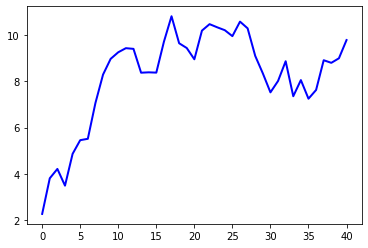

In [4]:
# 시계열 시각화.
plt.plot(df.Value, c="b", linewidth=2, linestyle="-")
plt.show()

#### 1.2. 지수 평활화 방법을 적용한 예측: 

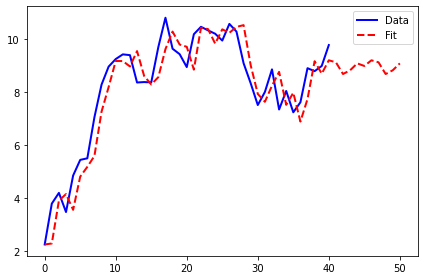

In [5]:
model = ExponentialSmoothing(df['Value'][0:40], seasonal='mul',seasonal_periods=6).fit()    # "승법 모델" 적용.
pred = model.predict(start= 0, end=50)                                                        
plt.plot(df,c='b',linewidth=2, linestyle="-", label="Data")
plt.plot(pred,c='r',linewidth=2, linestyle="--", label="Fit")
plt.legend()
plt.tight_layout()
plt.show()

### 2. 딥러닝 (RNN, LSTM) 방법으로 예측:

#### 2.1. 데이터 전처리:

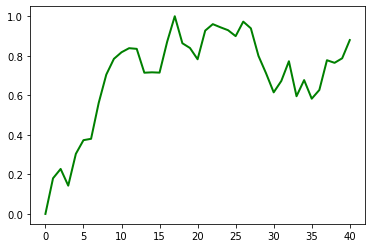

In [6]:
# Scaling.
# 아래 그래프에서 세로축의 scale에 주목!
my_scaler = MinMaxScaler()
ts_scaled = my_scaler.fit_transform(df)
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [7]:
# Reshaping.
ts_scaled_2 = ts_scaled.reshape(1,-1,1)             # (batch_size, time series length, n_input)

#### 2.2. 딥러닝 모델 정의:

Hyperparameters.

In [8]:
n_epochs = 4000                   
batch_size = 1                    # 데이터로 주어진 시계열은 단 한 개. 그러므로 batch_size = 1 이외의 선택은 없다.  
learn_rate = 0.0001       

In [9]:
n_input = 1                       # Scalar 값 입력.
n_hidden = 100                   # 층 별 neuron의 수.
n_output = 1                      # Scalar 값 출력.

Sequence to Sequence Model.

In [10]:
# RNN 또는 LSTM network.
# return_sequences = True: "Sequence to Sequence" 모델을 의미한다.
# input_shape = (None, n_input) :  "None"은 가변적인 시계열 길이를 나타낸다.
my_model = Sequential()
my_model.add(SimpleRNN(units=n_hidden,return_sequences=True, input_shape=(None, n_input), activation="relu"))     # RNN.
#my_model.add(LSTM(units=n_hidden,return_sequences=True, input_shape=(None, n_input),activation="relu"))         # LSTM.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [11]:
# 모델의 summary (내부 구조) 출력.
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

#### 2.3. 학습 진행:

In [13]:
# No validation.
# 주의: y 는 X를 +1 shifting 한 것이다!!!
my_EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)          # 조기 종료 허락!
my_summary = my_model.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 1, callbacks=[my_EarlyStop])

Epoch 1/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.8540 - mse: 0.8540
Epoch 2/4000
1/1 [==============================] - 0s 1ms/step - loss: 0.8425 - mse: 0.8425
Epoch 3/4000
1/1 [==============================] - 0s 1ms/step - loss: 0.8311 - mse: 0.8311
Epoch 4/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.8200 - mse: 0.8200
Epoch 5/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.8091 - mse: 0.8091
Epoch 6/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.7983 - mse: 0.7983
Epoch 7/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.7877 - mse: 0.7877
Epoch 8/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.7773 - mse: 0.7773
Epoch 9/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.7670 - mse: 0.7670
Epoch 10/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.7568 - mse: 0.7568
Epoch 11/4000
1/1 [==============================] - 0s 2ms/step - lo

1/1 [==============================] - 0s 2ms/step - loss: 0.3783 - mse: 0.3783
Epoch 58/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.3720 - mse: 0.3720
Epoch 59/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.3657 - mse: 0.3657
Epoch 60/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.3593 - mse: 0.3593
Epoch 61/4000
1/1 [==============================] - 0s 997us/step - loss: 0.3530 - mse: 0.3530
Epoch 62/4000
1/1 [==============================] - 0s 998us/step - loss: 0.3468 - mse: 0.3468
Epoch 63/4000
1/1 [==============================] - 0s 998us/step - loss: 0.3405 - mse: 0.3405
Epoch 64/4000
1/1 [==============================] - 0s 998us/step - loss: 0.3342 - mse: 0.3342
Epoch 65/4000
1/1 [==============================] - 0s 998us/step - loss: 0.3280 - mse: 0.3280
Epoch 66/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.3216 - mse: 0.3216
Epoch 67/4000
1/1 [==============================] - 0s 997us/st

Epoch 113/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0319 - mse: 0.0319
Epoch 114/4000
1/1 [==============================] - 0s 1000us/step - loss: 0.0294 - mse: 0.0294
Epoch 115/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0276 - mse: 0.0276
Epoch 116/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0263 - mse: 0.0263
Epoch 117/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0256 - mse: 0.0256
Epoch 118/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0255 - mse: 0.0255
Epoch 119/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0257 - mse: 0.0257
Epoch 120/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0260 - mse: 0.0260
Epoch 121/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0264 - mse: 0.0264
Epoch 122/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0267 - mse: 0.0267
Epoch 123/4000
1/1 [=======================

Epoch 141/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0198 - mse: 0.0198
Epoch 142/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0197 - mse: 0.0197
Epoch 143/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0196 - mse: 0.0196
Epoch 144/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0194 - mse: 0.0194
Epoch 145/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0192 - mse: 0.0192
Epoch 146/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0191 - mse: 0.0191
Epoch 147/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0189 - mse: 0.0189
Epoch 148/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0187 - mse: 0.0187
Epoch 149/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0185 - mse: 0.0185
Epoch 150/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183 - mse: 0.0183
Epoch 151/4000
1/1 [======================

Epoch 169/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150 - mse: 0.0150
Epoch 170/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149 - mse: 0.0149
Epoch 171/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148 - mse: 0.0148
Epoch 172/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147 - mse: 0.0147
Epoch 173/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145 - mse: 0.0145
Epoch 174/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144 - mse: 0.0144
Epoch 175/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0143 - mse: 0.0143
Epoch 176/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142 - mse: 0.0142
Epoch 177/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141 - mse: 0.0141
Epoch 178/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0140 - mse: 0.0140
Epoch 179/4000
1/1 [==========================

Epoch 197/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120 - mse: 0.0120
Epoch 198/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0119 - mse: 0.0119
Epoch 199/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118 - mse: 0.0118
Epoch 200/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117 - mse: 0.0117
Epoch 201/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116 - mse: 0.0116
Epoch 202/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115 - mse: 0.0115
Epoch 203/4000
1/1 [==============================] - 0s 995us/step - loss: 0.0114 - mse: 0.0114
Epoch 204/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113 - mse: 0.0113
Epoch 205/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0112 - mse: 0.0112
Epoch 206/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111 - mse: 0.0111
Epoch 207/4000
1/1 [========================

Epoch 225/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0100 - mse: 0.0100
Epoch 226/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099 - mse: 0.0099
Epoch 227/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099 - mse: 0.0099
Epoch 228/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 0.0098
Epoch 229/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0098 - mse: 0.0098
Epoch 230/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0098 - mse: 0.0098
Epoch 231/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0097 - mse: 0.0097
Epoch 232/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0097 - mse: 0.0097
Epoch 233/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096
Epoch 234/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096
Epoch 235/4000
1/1 [==============================

Epoch 253/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090
Epoch 254/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0090 - mse: 0.0090
Epoch 255/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0090 - mse: 0.0090
Epoch 256/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0089 - mse: 0.0089
Epoch 257/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0089 - mse: 0.0089
Epoch 258/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0089 - mse: 0.0089
Epoch 259/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0089 - mse: 0.0089
Epoch 260/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0089 - mse: 0.0089
Epoch 261/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0088 - mse: 0.0088
Epoch 262/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0088 - mse: 0.0088
Epoch 263/4000
1/1 [====================

Epoch 281/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0085 - mse: 0.0085
Epoch 282/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0084 - mse: 0.0084
Epoch 283/4000
1/1 [==============================] - 0s 974us/step - loss: 0.0084 - mse: 0.0084
Epoch 284/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0084 - mse: 0.0084
Epoch 285/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0084 - mse: 0.0084
Epoch 286/4000
1/1 [==============================] - 0s 995us/step - loss: 0.0084 - mse: 0.0084
Epoch 287/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0084 - mse: 0.0084
Epoch 288/4000
1/1 [==============================] - 0s 995us/step - loss: 0.0084 - mse: 0.0084
Epoch 289/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0083 - mse: 0.0083
Epoch 290/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0083 - mse: 0.0083
Epoch 291/4000
1/1 [==================

Epoch 309/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 310/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 311/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0081 - mse: 0.0081
Epoch 312/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 313/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 314/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 315/4000
1/1 [==============================] - 0s 963us/step - loss: 0.0081 - mse: 0.0081
Epoch 316/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 317/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 318/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0081 - mse: 0.0081
Epoch 319/4000
1/1 [========================

Epoch 337/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 338/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 339/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0079 - mse: 0.0079
Epoch 340/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 341/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 342/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0079 - mse: 0.0079
Epoch 343/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 344/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0079 - mse: 0.0079
Epoch 345/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 346/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 347/4000
1/1 [============================

Epoch 365/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077
Epoch 366/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077
Epoch 367/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077
Epoch 368/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077
Epoch 369/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077
Epoch 370/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077
Epoch 371/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077
Epoch 372/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0077 - mse: 0.0077
Epoch 373/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0077 - mse: 0.0077
Epoch 374/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077
Epoch 375/4000
1/1 [==========================

Epoch 393/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076
Epoch 394/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0075 - mse: 0.0075
Epoch 395/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0075 - mse: 0.0075
Epoch 396/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0075 - mse: 0.0075
Epoch 397/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0075 - mse: 0.0075
Epoch 398/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0075 - mse: 0.0075
Epoch 399/4000
1/1 [==============================] - 0s 987us/step - loss: 0.0075 - mse: 0.0075
Epoch 400/4000
1/1 [==============================] - 0s 969us/step - loss: 0.0075 - mse: 0.0075
Epoch 401/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0075 - mse: 0.0075
Epoch 402/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0075 - mse: 0.0075
Epoch 403/4000
1/1 [====================

Epoch 421/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074
Epoch 422/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074
Epoch 423/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074
Epoch 424/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074
Epoch 425/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074
Epoch 426/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074
Epoch 427/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0074 - mse: 0.0074
Epoch 428/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0074 - mse: 0.0074
Epoch 429/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0074 - mse: 0.0074
Epoch 430/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0073 - mse: 0.0073
Epoch 431/4000
1/1 [==========================

Epoch 449/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072
Epoch 450/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072
Epoch 451/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072
Epoch 452/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0072 - mse: 0.0072
Epoch 453/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0072 - mse: 0.0072
Epoch 454/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072
Epoch 455/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0072 - mse: 0.0072
Epoch 456/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072
Epoch 457/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0072 - mse: 0.0072
Epoch 458/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072
Epoch 459/4000
1/1 [======================

Epoch 477/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0070 - mse: 0.0070
Epoch 478/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 479/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 480/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 481/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 482/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 483/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0070 - mse: 0.0070
Epoch 484/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 485/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 486/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 487/4000
1/1 [==========================

Epoch 505/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0068 - mse: 0.0068
Epoch 506/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0068 - mse: 0.0068
Epoch 507/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0068 - mse: 0.0068
Epoch 508/4000
1/1 [==============================] - 0s 1ms/step - loss: 0.0068 - mse: 0.0068
Epoch 509/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0068 - mse: 0.0068
Epoch 510/4000
1/1 [==============================] - 0s 1ms/step - loss: 0.0068 - mse: 0.0068
Epoch 511/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0067 - mse: 0.0067
Epoch 512/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0067 - mse: 0.0067
Epoch 513/4000
1/1 [==============================] - 0s 991us/step - loss: 0.0067 - mse: 0.0067
Epoch 514/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0067 - mse: 0.0067
Epoch 515/4000
1/1 [========================

Epoch 533/4000
1/1 [==============================] - 0s 995us/step - loss: 0.0065 - mse: 0.0065
Epoch 534/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - mse: 0.0065
Epoch 535/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - mse: 0.0065
Epoch 536/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - mse: 0.0065
Epoch 537/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - mse: 0.0065
Epoch 538/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0065 - mse: 0.0065
Epoch 539/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0065 - mse: 0.0065
Epoch 540/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - mse: 0.0065
Epoch 541/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - mse: 0.0065
Epoch 542/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0064 - mse: 0.0064
Epoch 543/4000
1/1 [======================

Epoch 561/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0063 - mse: 0.0063
Epoch 562/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0063 - mse: 0.0063
Epoch 563/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062
Epoch 564/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0062 - mse: 0.0062
Epoch 565/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062
Epoch 566/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062
Epoch 567/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0062 - mse: 0.0062
Epoch 568/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062
Epoch 569/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062
Epoch 570/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062
Epoch 571/4000
1/1 [========================

Epoch 589/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 0.0060
Epoch 590/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0060 - mse: 0.0060
Epoch 591/4000
1/1 [==============================] - 0s 963us/step - loss: 0.0060 - mse: 0.0060
Epoch 592/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 0.0060
Epoch 593/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0060 - mse: 0.0060
Epoch 594/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 0.0060
Epoch 595/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 0.0059
Epoch 596/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0059 - mse: 0.0059
Epoch 597/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0059 - mse: 0.0059
Epoch 598/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 0.0059
Epoch 599/4000
1/1 [======================

Epoch 617/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0057 - mse: 0.0057
Epoch 618/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0057 - mse: 0.0057
Epoch 619/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0057 - mse: 0.0057
Epoch 620/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0057 - mse: 0.0057
Epoch 621/4000
1/1 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 0.0057
Epoch 622/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0057 - mse: 0.0057
Epoch 623/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0057 - mse: 0.0057
Epoch 624/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0057 - mse: 0.0057
Epoch 625/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0056 - mse: 0.0056
Epoch 626/4000
1/1 [==============================] - 0s 995us/step - loss: 0.0056 - mse: 0.0056
Epoch 627/4000
1/1 [====================

Epoch 645/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0054 - mse: 0.0054
Epoch 646/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0054 - mse: 0.0054
Epoch 647/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0054 - mse: 0.0054
Epoch 648/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 0.0054
Epoch 649/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0054 - mse: 0.0054
Epoch 650/4000
1/1 [==============================] - 0s 994us/step - loss: 0.0054 - mse: 0.0054
Epoch 651/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0054 - mse: 0.0054
Epoch 652/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 0.0054
Epoch 653/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 0.0053
Epoch 654/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0053 - mse: 0.0053
Epoch 655/4000
1/1 [================

Epoch 673/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 0.0051
Epoch 674/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 0.0051
Epoch 675/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0051 - mse: 0.0051
Epoch 676/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0051 - mse: 0.0051
Epoch 677/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0051 - mse: 0.0051
Epoch 678/4000
1/1 [==============================] - 0s 1000us/step - loss: 0.0051 - mse: 0.0051
Epoch 679/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0051 - mse: 0.0051
Epoch 680/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 0.0051
Epoch 681/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0050 - mse: 0.0050
Epoch 682/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 0.0050
Epoch 683/4000
1/1 [=================

Epoch 701/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0048 - mse: 0.0048
Epoch 702/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0048
Epoch 703/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - mse: 0.0047
Epoch 704/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - mse: 0.0047
Epoch 705/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - mse: 0.0047
Epoch 706/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - mse: 0.0047
Epoch 707/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0046 - mse: 0.0046
Epoch 708/4000
1/1 [==============================] - 0s 1000us/step - loss: 0.0046 - mse: 0.0046
Epoch 709/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0046 - mse: 0.0046
Epoch 710/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0046 - mse: 0.0046
Epoch 711/4000
1/1 [=====================

Epoch 729/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0043 - mse: 0.0043
Epoch 730/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043
Epoch 731/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0043 - mse: 0.0043
Epoch 732/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043
Epoch 733/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042
Epoch 734/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042
Epoch 735/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0042 - mse: 0.0042
Epoch 736/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042
Epoch 737/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0042 - mse: 0.0042
Epoch 738/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0042 - mse: 0.0042
Epoch 739/4000
1/1 [====================

Epoch 757/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - mse: 0.0039
Epoch 758/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - mse: 0.0039
Epoch 759/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - mse: 0.0039
Epoch 760/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0039 - mse: 0.0039
Epoch 761/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - mse: 0.0039
Epoch 762/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - mse: 0.0039
Epoch 763/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - mse: 0.0039
Epoch 764/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - mse: 0.0038
Epoch 765/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0038 - mse: 0.0038
Epoch 766/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - mse: 0.0038
Epoch 767/4000
1/1 [==========================

Epoch 785/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0036 - mse: 0.0036
Epoch 786/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0036 - mse: 0.0036
Epoch 787/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 0.0036
Epoch 788/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 0.0036
Epoch 789/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0035 - mse: 0.0035
Epoch 790/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035
Epoch 791/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035
Epoch 792/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0035 - mse: 0.0035
Epoch 793/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0035 - mse: 0.0035
Epoch 794/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035
Epoch 795/4000
1/1 [====================

Epoch 813/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032
Epoch 814/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032
Epoch 815/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032
Epoch 816/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0032 - mse: 0.0032
Epoch 817/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0032 - mse: 0.0032
Epoch 818/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032
Epoch 819/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0032 - mse: 0.0032
Epoch 820/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031
Epoch 821/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031
Epoch 822/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0031 - mse: 0.0031
Epoch 823/4000
1/1 [======================

Epoch 841/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0029 - mse: 0.0029
Epoch 842/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029
Epoch 843/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0029 - mse: 0.0029
Epoch 844/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0029 - mse: 0.0029
Epoch 845/4000
1/1 [==============================] - 0s 972us/step - loss: 0.0029 - mse: 0.0029
Epoch 846/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029
Epoch 847/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028
Epoch 848/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028
Epoch 849/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028
Epoch 850/4000
1/1 [==============================] - 0s 1ms/step - loss: 0.0028 - mse: 0.0028
Epoch 851/4000
1/1 [======================

Epoch 869/4000
1/1 [==============================] - 0s 999us/step - loss: 0.0026 - mse: 0.0026
Epoch 870/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0026 - mse: 0.0026
Epoch 871/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026
Epoch 872/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026
Epoch 873/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0026 - mse: 0.0026
Epoch 874/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026
Epoch 875/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026
Epoch 876/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026
Epoch 877/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0026 - mse: 0.0026
Epoch 878/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0026 - mse: 0.0026
Epoch 879/4000
1/1 [====================

Epoch 897/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024
Epoch 898/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024
Epoch 899/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024
Epoch 900/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024
Epoch 901/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 0.0024
Epoch 902/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0024 - mse: 0.0024
Epoch 903/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 904/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 905/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 906/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 907/4000
1/1 [============================

Epoch 925/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0022 - mse: 0.0022
Epoch 926/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0022 - mse: 0.0022
Epoch 927/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - mse: 0.0021
Epoch 928/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021 - mse: 0.0021
Epoch 929/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021 - mse: 0.0021
Epoch 930/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021 - mse: 0.0021
Epoch 931/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - mse: 0.0021
Epoch 932/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - mse: 0.0021
Epoch 933/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - mse: 0.0021
Epoch 934/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0021 - mse: 0.0021
Epoch 935/4000
1/1 [================

Epoch 953/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 0.0020
Epoch 954/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0020 - mse: 0.0020
Epoch 955/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0020 - mse: 0.0020
Epoch 956/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019
Epoch 957/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - mse: 0.0019
Epoch 958/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - mse: 0.0019
Epoch 959/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - mse: 0.0019
Epoch 960/4000
1/1 [==============================] - 0s 973us/step - loss: 0.0019 - mse: 0.0019
Epoch 961/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - mse: 0.0019
Epoch 962/4000
1/1 [==============================] - 0s 964us/step - loss: 0.0019 - mse: 0.0019
Epoch 963/4000
1/1 [==============

Epoch 981/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - mse: 0.0018
Epoch 982/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0018 - mse: 0.0018
Epoch 983/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018
Epoch 984/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0018 - mse: 0.0018
Epoch 985/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - mse: 0.0018
Epoch 986/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - mse: 0.0018
Epoch 987/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018
Epoch 988/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018
Epoch 989/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018
Epoch 990/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017
Epoch 991/4000
1/1 [====================

Epoch 1009/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - mse: 0.0017
Epoch 1010/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0017 - mse: 0.0017
Epoch 1011/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - mse: 0.0016
Epoch 1012/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 1013/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 1014/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 1015/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 1016/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - mse: 0.0016
Epoch 1017/4000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016
Epoch 1018/4000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016
Epoch 1019/4000
1/1 [===========

Epoch 1037/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0015 - mse: 0.0015
Epoch 1038/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0015 - mse: 0.0015
Epoch 1039/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0015 - mse: 0.0015
Epoch 1040/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015
Epoch 1041/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015
Epoch 1042/4000
1/1 [==============================] - 0s 988us/step - loss: 0.0015 - mse: 0.0015
Epoch 1043/4000
1/1 [==============================] - 0s 995us/step - loss: 0.0015 - mse: 0.0015
Epoch 1044/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0015 - mse: 0.0015
Epoch 1045/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0015 - mse: 0.0015
Epoch 1046/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015
Epoch 1047/4000
1/1 [=====

Epoch 1065/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014
Epoch 1066/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0014 - mse: 0.0014
Epoch 1067/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0014 - mse: 0.0014
Epoch 1068/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013
Epoch 1069/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013
Epoch 1070/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0013 - mse: 0.0013
Epoch 1071/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0013 - mse: 0.0013
Epoch 1072/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0013 - mse: 0.0013
Epoch 1073/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0013 - mse: 0.0013
Epoch 1074/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013
Epoch 1075/4000
1/1 [=======

Epoch 1093/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012
Epoch 1094/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012
Epoch 1095/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012
Epoch 1096/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0012 - mse: 0.0012
Epoch 1097/4000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012
Epoch 1098/4000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012
Epoch 1099/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012
Epoch 1100/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012
Epoch 1101/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0012 - mse: 0.0012
Epoch 1102/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012
Epoch 1103/4000
1/1 [===============

Epoch 1121/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010
Epoch 1122/4000
1/1 [==============================] - 0s 998us/step - loss: 0.0010 - mse: 0.0010
Epoch 1123/4000
1/1 [==============================] - 0s 996us/step - loss: 0.0010 - mse: 0.0010
Epoch 1124/4000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010
Epoch 1125/4000
1/1 [==============================] - 0s 997us/step - loss: 0.0010 - mse: 0.0010
Epoch 1126/4000
1/1 [==============================] - 0s 997us/step - loss: 9.9539e-04 - mse: 9.9539e-04
Epoch 1127/4000
1/1 [==============================] - 0s 998us/step - loss: 9.8523e-04 - mse: 9.8523e-04
Epoch 1128/4000
1/1 [==============================] - 0s 997us/step - loss: 9.7928e-04 - mse: 9.7928e-04
Epoch 1129/4000
1/1 [==============================] - 0s 326us/step - loss: 9.7481e-04 - mse: 9.7481e-04
Epoch 1130/4000
1/1 [==============================] - 0s 997us/step - loss: 9.7000e-04 - 

1/1 [==============================] - 0s 1ms/step - loss: 8.7478e-04 - mse: 8.7478e-04
Epoch 1148/4000
1/1 [==============================] - 0s 996us/step - loss: 8.6894e-04 - mse: 8.6894e-04
Epoch 1149/4000
1/1 [==============================] - 0s 998us/step - loss: 8.6376e-04 - mse: 8.6376e-04
Epoch 1150/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.5818e-04 - mse: 8.5818e-04
Epoch 1151/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.5430e-04 - mse: 8.5430e-04
Epoch 1152/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.4788e-04 - mse: 8.4788e-04
Epoch 1153/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.4292e-04 - mse: 8.4292e-04
Epoch 1154/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.3776e-04 - mse: 8.3776e-04
Epoch 1155/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.3305e-04 - mse: 8.3305e-04
Epoch 1156/4000
1/1 [==============================] - 0s 996us/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 6.5743e-04 - mse: 6.5743e-04
Epoch 1201/4000
1/1 [==============================] - 0s 998us/step - loss: 6.5442e-04 - mse: 6.5442e-04
Epoch 1202/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.5092e-04 - mse: 6.5092e-04
Epoch 1203/4000
1/1 [==============================] - 0s 998us/step - loss: 6.4778e-04 - mse: 6.4778e-04
Epoch 1204/4000
1/1 [==============================] - 0s 962us/step - loss: 6.4436e-04 - mse: 6.4436e-04
Epoch 1205/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.4104e-04 - mse: 6.4104e-04
Epoch 1206/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.3753e-04 - mse: 6.3753e-04
Epoch 1207/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.3510e-04 - mse: 6.3510e-04
Epoch 1208/4000
1/1 [==============================] - 0s 1ms/step - loss: 6.3126e-04 - mse: 6.3126e-04
Epoch 1209/4000
1/1 [==============================] - 0s 1ms/step - loss:

1/1 [==============================] - 0s 997us/step - loss: 5.1262e-04 - mse: 5.1262e-04
Epoch 1254/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.1035e-04 - mse: 5.1035e-04
Epoch 1255/4000
1/1 [==============================] - 0s 998us/step - loss: 5.0863e-04 - mse: 5.0863e-04
Epoch 1256/4000
1/1 [==============================] - 0s 997us/step - loss: 5.0655e-04 - mse: 5.0655e-04
Epoch 1257/4000
1/1 [==============================] - 0s 997us/step - loss: 5.0434e-04 - mse: 5.0434e-04
Epoch 1258/4000
1/1 [==============================] - 0s 998us/step - loss: 5.0218e-04 - mse: 5.0218e-04
Epoch 1259/4000
1/1 [==============================] - 0s 1ms/step - loss: 5.0012e-04 - mse: 5.0012e-04
Epoch 1260/4000
1/1 [==============================] - 0s 964us/step - loss: 4.9799e-04 - mse: 4.9799e-04
Epoch 1261/4000
1/1 [==============================] - 0s 962us/step - loss: 4.9597e-04 - mse: 4.9597e-04
Epoch 1262/4000
1/1 [==============================] - 0s 996us/st

1/1 [==============================] - 0s 998us/step - loss: 4.5963e-04 - mse: 4.5963e-04
Epoch 1281/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.5723e-04 - mse: 4.5723e-04
Epoch 1282/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.5551e-04 - mse: 4.5551e-04
Epoch 1283/4000
1/1 [==============================] - 0s 997us/step - loss: 4.5273e-04 - mse: 4.5273e-04
Epoch 1284/4000
1/1 [==============================] - 0s 997us/step - loss: 4.5170e-04 - mse: 4.5170e-04
Epoch 1285/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.4950e-04 - mse: 4.4950e-04
Epoch 1286/4000
1/1 [==============================] - 0s 997us/step - loss: 4.4818e-04 - mse: 4.4818e-04
Epoch 1287/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.4581e-04 - mse: 4.4581e-04
Epoch 1288/4000
1/1 [==============================] - 0s 963us/step - loss: 4.4417e-04 - mse: 4.4417e-04
Epoch 1289/4000
1/1 [==============================] - 0s 997us/step -

1/1 [==============================] - 0s 2ms/step - loss: 4.1181e-04 - mse: 4.1181e-04
Epoch 1307/4000
1/1 [==============================] - 0s 998us/step - loss: 4.1081e-04 - mse: 4.1081e-04
Epoch 1308/4000
1/1 [==============================] - 0s 3ms/step - loss: 4.0871e-04 - mse: 4.0871e-04
Epoch 1309/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.0799e-04 - mse: 4.0799e-04
Epoch 1310/4000
1/1 [==============================] - 0s 996us/step - loss: 4.0561e-04 - mse: 4.0561e-04
Epoch 1311/4000
1/1 [==============================] - 0s 997us/step - loss: 4.0497e-04 - mse: 4.0497e-04
Epoch 1312/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.0252e-04 - mse: 4.0252e-04
Epoch 1313/4000
1/1 [==============================] - 0s 998us/step - loss: 4.0074e-04 - mse: 4.0074e-04
Epoch 1314/4000
1/1 [==============================] - 0s 3ms/step - loss: 3.9899e-04 - mse: 3.9899e-04
Epoch 1315/4000
1/1 [==============================] - 0s 2ms/step - los

1/1 [==============================] - 0s 2ms/step - loss: 3.3347e-04 - mse: 3.3347e-04
Epoch 1360/4000
1/1 [==============================] - 0s 996us/step - loss: 3.3222e-04 - mse: 3.3222e-04
Epoch 1361/4000
1/1 [==============================] - 0s 998us/step - loss: 3.3059e-04 - mse: 3.3059e-04
Epoch 1362/4000
1/1 [==============================] - 0s 997us/step - loss: 3.2994e-04 - mse: 3.2994e-04
Epoch 1363/4000
1/1 [==============================] - 0s 998us/step - loss: 3.2796e-04 - mse: 3.2796e-04
Epoch 1364/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.2726e-04 - mse: 3.2726e-04
Epoch 1365/4000
1/1 [==============================] - 0s 997us/step - loss: 3.2490e-04 - mse: 3.2490e-04
Epoch 1366/4000
1/1 [==============================] - 0s 997us/step - loss: 3.2403e-04 - mse: 3.2403e-04
Epoch 1367/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.2226e-04 - mse: 3.2226e-04
Epoch 1368/4000
1/1 [==============================] - 0s 997us/step

1/1 [==============================] - 0s 2ms/step - loss: 2.9554e-04 - mse: 2.9554e-04
Epoch 1387/4000
1/1 [==============================] - 0s 1ms/step - loss: 2.9461e-04 - mse: 2.9461e-04
Epoch 1388/4000
1/1 [==============================] - 0s 1ms/step - loss: 2.9322e-04 - mse: 2.9322e-04
Epoch 1389/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.9209e-04 - mse: 2.9209e-04
Epoch 1390/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.9124e-04 - mse: 2.9124e-04
Epoch 1391/4000
1/1 [==============================] - 0s 997us/step - loss: 2.8975e-04 - mse: 2.8975e-04
Epoch 1392/4000
1/1 [==============================] - 0s 997us/step - loss: 2.8803e-04 - mse: 2.8803e-04
Epoch 1393/4000
1/1 [==============================] - 0s 998us/step - loss: 2.8678e-04 - mse: 2.8678e-04
Epoch 1394/4000
1/1 [==============================] - 0s 998us/step - loss: 2.8610e-04 - mse: 2.8610e-04
Epoch 1395/4000
1/1 [==============================] - 0s 1000us/step - 

1/1 [==============================] - 0s 998us/step - loss: 2.6449e-04 - mse: 2.6449e-04
Epoch 1413/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.6347e-04 - mse: 2.6347e-04
Epoch 1414/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.6215e-04 - mse: 2.6215e-04
Epoch 1415/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.6110e-04 - mse: 2.6110e-04
Epoch 1416/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.6013e-04 - mse: 2.6013e-04
Epoch 1417/4000
1/1 [==============================] - 0s 998us/step - loss: 2.5874e-04 - mse: 2.5874e-04
Epoch 1418/4000
1/1 [==============================] - 0s 803us/step - loss: 2.5759e-04 - mse: 2.5759e-04
Epoch 1419/4000
1/1 [==============================] - 0s 997us/step - loss: 2.5688e-04 - mse: 2.5688e-04
Epoch 1420/4000
1/1 [==============================] - 0s 996us/step - loss: 2.5522e-04 - mse: 2.5522e-04
Epoch 1421/4000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 1ms/step - loss: 2.3502e-04 - mse: 2.3502e-04
Epoch 1440/4000
1/1 [==============================] - 0s 999us/step - loss: 2.3395e-04 - mse: 2.3395e-04
Epoch 1441/4000
1/1 [==============================] - 0s 999us/step - loss: 2.3299e-04 - mse: 2.3299e-04
Epoch 1442/4000
1/1 [==============================] - 0s 997us/step - loss: 2.3211e-04 - mse: 2.3211e-04
Epoch 1443/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.3066e-04 - mse: 2.3066e-04
Epoch 1444/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.2946e-04 - mse: 2.2946e-04
Epoch 1445/4000
1/1 [==============================] - 0s 998us/step - loss: 2.2896e-04 - mse: 2.2896e-04
Epoch 1446/4000
1/1 [==============================] - 0s 997us/step - loss: 2.2749e-04 - mse: 2.2749e-04
Epoch 1447/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.2630e-04 - mse: 2.2630e-04
Epoch 1448/4000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 2.0904e-04 - mse: 2.0904e-04
Epoch 1466/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.0755e-04 - mse: 2.0755e-04
Epoch 1467/4000
1/1 [==============================] - 0s 998us/step - loss: 2.0666e-04 - mse: 2.0666e-04
Epoch 1468/4000
1/1 [==============================] - 0s 998us/step - loss: 2.0597e-04 - mse: 2.0597e-04
Epoch 1469/4000
1/1 [==============================] - 0s 997us/step - loss: 2.0484e-04 - mse: 2.0484e-04
Epoch 1470/4000
1/1 [==============================] - 0s 997us/step - loss: 2.0371e-04 - mse: 2.0371e-04
Epoch 1471/4000
1/1 [==============================] - 0s 997us/step - loss: 2.0373e-04 - mse: 2.0373e-04
Epoch 1472/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.0254e-04 - mse: 2.0254e-04
Epoch 1473/4000
1/1 [==============================] - 0s 998us/step - loss: 2.0125e-04 - mse: 2.0125e-04
Epoch 1474/4000
1/1 [==============================] - 0s 998us/step

1/1 [==============================] - 0s 998us/step - loss: 1.8473e-04 - mse: 1.8473e-04
Epoch 1493/4000
1/1 [==============================] - 0s 997us/step - loss: 1.8381e-04 - mse: 1.8381e-04
Epoch 1494/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.8284e-04 - mse: 1.8284e-04
Epoch 1495/4000
1/1 [==============================] - 0s 998us/step - loss: 1.8208e-04 - mse: 1.8208e-04
Epoch 1496/4000
1/1 [==============================] - 0s 960us/step - loss: 1.8119e-04 - mse: 1.8119e-04
Epoch 1497/4000
1/1 [==============================] - 0s 971us/step - loss: 1.8030e-04 - mse: 1.8030e-04
Epoch 1498/4000
1/1 [==============================] - 0s 971us/step - loss: 1.7959e-04 - mse: 1.7959e-04
Epoch 1499/4000
1/1 [==============================] - 0s 998us/step - loss: 1.7921e-04 - mse: 1.7921e-04
Epoch 1500/4000
1/1 [==============================] - 0s 997us/step - loss: 1.7822e-04 - mse: 1.7822e-04
Epoch 1501/4000
1/1 [==============================] - 0s 998us/

1/1 [==============================] - 0s 964us/step - loss: 1.6485e-04 - mse: 1.6485e-04
Epoch 1519/4000
1/1 [==============================] - 0s 997us/step - loss: 1.6417e-04 - mse: 1.6417e-04
Epoch 1520/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.6329e-04 - mse: 1.6329e-04
Epoch 1521/4000
1/1 [==============================] - 0s 996us/step - loss: 1.6252e-04 - mse: 1.6252e-04
Epoch 1522/4000
1/1 [==============================] - 0s 996us/step - loss: 1.6189e-04 - mse: 1.6189e-04
Epoch 1523/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.6123e-04 - mse: 1.6123e-04
Epoch 1524/4000
1/1 [==============================] - 0s 997us/step - loss: 1.6045e-04 - mse: 1.6045e-04
Epoch 1525/4000
1/1 [==============================] - 0s 998us/step - loss: 1.5979e-04 - mse: 1.5979e-04
Epoch 1526/4000
1/1 [==============================] - 0s 997us/step - loss: 1.5912e-04 - mse: 1.5912e-04
Epoch 1527/4000
1/1 [==============================] - 0s 997us/st

1/1 [==============================] - 0s 997us/step - loss: 1.4714e-04 - mse: 1.4714e-04
Epoch 1546/4000
1/1 [==============================] - 0s 998us/step - loss: 1.4614e-04 - mse: 1.4614e-04
Epoch 1547/4000
1/1 [==============================] - 0s 997us/step - loss: 1.4562e-04 - mse: 1.4562e-04
Epoch 1548/4000
1/1 [==============================] - 0s 998us/step - loss: 1.4523e-04 - mse: 1.4523e-04
Epoch 1549/4000
1/1 [==============================] - 0s 997us/step - loss: 1.4443e-04 - mse: 1.4443e-04
Epoch 1550/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.4393e-04 - mse: 1.4393e-04
Epoch 1551/4000
1/1 [==============================] - 0s 997us/step - loss: 1.4301e-04 - mse: 1.4301e-04
Epoch 1552/4000
1/1 [==============================] - 0s 997us/step - loss: 1.4273e-04 - mse: 1.4273e-04
Epoch 1553/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.4189e-04 - mse: 1.4189e-04
Epoch 1554/4000
1/1 [==============================] - 0s 999us/st

1/1 [==============================] - 0s 998us/step - loss: 1.3190e-04 - mse: 1.3190e-04
Epoch 1572/4000
1/1 [==============================] - 0s 351us/step - loss: 1.3130e-04 - mse: 1.3130e-04
Epoch 1573/4000
1/1 [==============================] - 0s 963us/step - loss: 1.3076e-04 - mse: 1.3076e-04
Epoch 1574/4000
1/1 [==============================] - 0s 997us/step - loss: 1.3013e-04 - mse: 1.3013e-04
Epoch 1575/4000
1/1 [==============================] - 0s 964us/step - loss: 1.2946e-04 - mse: 1.2946e-04
Epoch 1576/4000
1/1 [==============================] - 0s 979us/step - loss: 1.2908e-04 - mse: 1.2908e-04
Epoch 1577/4000
1/1 [==============================] - 0s 997us/step - loss: 1.2845e-04 - mse: 1.2845e-04
Epoch 1578/4000
1/1 [==============================] - 0s 998us/step - loss: 1.2826e-04 - mse: 1.2826e-04
Epoch 1579/4000
1/1 [==============================] - 0s 997us/step - loss: 1.2734e-04 - mse: 1.2734e-04
Epoch 1580/4000
1/1 [==============================] - 0s 997u

Epoch 1598/4000
1/1 [==============================] - 0s 1ms/step - loss: 1.1643e-04 - mse: 1.1643e-04
Epoch 1599/4000
1/1 [==============================] - 0s 996us/step - loss: 1.1574e-04 - mse: 1.1574e-04
Epoch 1600/4000
1/1 [==============================] - 0s 1000us/step - loss: 1.1523e-04 - mse: 1.1523e-04
Epoch 1601/4000
1/1 [==============================] - 0s 996us/step - loss: 1.1462e-04 - mse: 1.1462e-04
Epoch 1602/4000
1/1 [==============================] - 0s 997us/step - loss: 1.1406e-04 - mse: 1.1406e-04
Epoch 1603/4000
1/1 [==============================] - 0s 997us/step - loss: 1.1353e-04 - mse: 1.1353e-04
Epoch 1604/4000
1/1 [==============================] - 0s 997us/step - loss: 1.1287e-04 - mse: 1.1287e-04
Epoch 1605/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.1241e-04 - mse: 1.1241e-04
Epoch 1606/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.1163e-04 - mse: 1.1163e-04
Epoch 1607/4000
1/1 [==============================

1/1 [==============================] - 0s 2ms/step - loss: 8.9672e-05 - mse: 8.9672e-05
Epoch 1651/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.9154e-05 - mse: 8.9154e-05
Epoch 1652/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.8568e-05 - mse: 8.8568e-05
Epoch 1653/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.8079e-05 - mse: 8.8079e-05
Epoch 1654/4000
1/1 [==============================] - 0s 998us/step - loss: 8.7768e-05 - mse: 8.7768e-05
Epoch 1655/4000
1/1 [==============================] - 0s 1000us/step - loss: 8.7207e-05 - mse: 8.7207e-05
Epoch 1656/4000
1/1 [==============================] - 0s 997us/step - loss: 8.6872e-05 - mse: 8.6872e-05
Epoch 1657/4000
1/1 [==============================] - 0s 997us/step - loss: 8.6405e-05 - mse: 8.6405e-05
Epoch 1658/4000
1/1 [==============================] - 0s 997us/step - loss: 8.5964e-05 - mse: 8.5964e-05
Epoch 1659/4000
1/1 [==============================] - 0s 999us/step 

1/1 [==============================] - 0s 2ms/step - loss: 7.7812e-05 - mse: 7.7812e-05
Epoch 1678/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.7396e-05 - mse: 7.7396e-05
Epoch 1679/4000
1/1 [==============================] - 0s 997us/step - loss: 7.7035e-05 - mse: 7.7035e-05
Epoch 1680/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.6672e-05 - mse: 7.6672e-05
Epoch 1681/4000
1/1 [==============================] - 0s 995us/step - loss: 7.6279e-05 - mse: 7.6279e-05
Epoch 1682/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.5842e-05 - mse: 7.5842e-05
Epoch 1683/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.5390e-05 - mse: 7.5390e-05
Epoch 1684/4000
1/1 [==============================] - 0s 990us/step - loss: 7.5104e-05 - mse: 7.5104e-05
Epoch 1685/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.4792e-05 - mse: 7.4792e-05
Epoch 1686/4000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 6.8208e-05 - mse: 6.8208e-05
Epoch 1704/4000
1/1 [==============================] - 0s 1ms/step - loss: 6.7820e-05 - mse: 6.7820e-05
Epoch 1705/4000
1/1 [==============================] - 0s 998us/step - loss: 6.7617e-05 - mse: 6.7617e-05
Epoch 1706/4000
1/1 [==============================] - 0s 997us/step - loss: 6.7410e-05 - mse: 6.7410e-05
Epoch 1707/4000
1/1 [==============================] - 0s 997us/step - loss: 6.6950e-05 - mse: 6.6950e-05
Epoch 1708/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.6461e-05 - mse: 6.6461e-05
Epoch 1709/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.6196e-05 - mse: 6.6196e-05
Epoch 1710/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.5658e-05 - mse: 6.5658e-05
Epoch 1711/4000
1/1 [==============================] - 0s 1ms/step - loss: 6.5655e-05 - mse: 6.5655e-05
Epoch 1712/4000
1/1 [==============================] - 0s 996us/step - los

1/1 [==============================] - 0s 2ms/step - loss: 6.0472e-05 - mse: 6.0472e-05
Epoch 1731/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.9983e-05 - mse: 5.9983e-05
Epoch 1732/4000
1/1 [==============================] - 0s 998us/step - loss: 5.9911e-05 - mse: 5.9911e-05
Epoch 1733/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.9762e-05 - mse: 5.9762e-05
Epoch 1734/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.9067e-05 - mse: 5.9067e-05
Epoch 1735/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.8868e-05 - mse: 5.8868e-05
Epoch 1736/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.8626e-05 - mse: 5.8626e-05
Epoch 1737/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.8251e-05 - mse: 5.8251e-05
Epoch 1738/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.8209e-05 - mse: 5.8209e-05
Epoch 1739/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.7

1/1 [==============================] - 0s 2ms/step - loss: 5.4055e-05 - mse: 5.4055e-05
Epoch 1757/4000
1/1 [==============================] - 0s 997us/step - loss: 5.3701e-05 - mse: 5.3701e-05
Epoch 1758/4000
1/1 [==============================] - 0s 970us/step - loss: 5.3553e-05 - mse: 5.3553e-05
Epoch 1759/4000
1/1 [==============================] - 0s 1ms/step - loss: 5.3269e-05 - mse: 5.3269e-05
Epoch 1760/4000
1/1 [==============================] - 0s 998us/step - loss: 5.3169e-05 - mse: 5.3169e-05
Epoch 1761/4000
1/1 [==============================] - 0s 998us/step - loss: 5.2790e-05 - mse: 5.2790e-05
Epoch 1762/4000
1/1 [==============================] - 0s 1ms/step - loss: 5.2812e-05 - mse: 5.2812e-05
Epoch 1763/4000
1/1 [==============================] - 0s 998us/step - loss: 5.2334e-05 - mse: 5.2334e-05
Epoch 1764/4000
1/1 [==============================] - 0s 999us/step - loss: 5.2112e-05 - mse: 5.2112e-05
Epoch 1765/4000
1/1 [==============================] - 0s 996us/step

1/1 [==============================] - 0s 1000us/step - loss: 4.3454e-05 - mse: 4.3454e-05
Epoch 1810/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.3281e-05 - mse: 4.3281e-05
Epoch 1811/4000
1/1 [==============================] - 0s 997us/step - loss: 4.3087e-05 - mse: 4.3087e-05
Epoch 1812/4000
1/1 [==============================] - 0s 996us/step - loss: 4.2855e-05 - mse: 4.2855e-05
Epoch 1813/4000
1/1 [==============================] - 0s 997us/step - loss: 4.2697e-05 - mse: 4.2697e-05
Epoch 1814/4000
1/1 [==============================] - 0s 997us/step - loss: 4.2557e-05 - mse: 4.2557e-05
Epoch 1815/4000
1/1 [==============================] - 0s 998us/step - loss: 4.2330e-05 - mse: 4.2330e-05
Epoch 1816/4000
1/1 [==============================] - 0s 996us/step - loss: 4.2243e-05 - mse: 4.2243e-05
Epoch 1817/4000
1/1 [==============================] - 0s 998us/step - loss: 4.2142e-05 - mse: 4.2142e-05
Epoch 1818/4000
1/1 [==============================] - 0s 996us

1/1 [==============================] - 0s 1000us/step - loss: 3.9155e-05 - mse: 3.9155e-05
Epoch 1836/4000
1/1 [==============================] - 0s 996us/step - loss: 3.8963e-05 - mse: 3.8963e-05
Epoch 1837/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.8917e-05 - mse: 3.8917e-05
Epoch 1838/4000
1/1 [==============================] - 0s 997us/step - loss: 3.8588e-05 - mse: 3.8588e-05
Epoch 1839/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.8663e-05 - mse: 3.8663e-05
Epoch 1840/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.8377e-05 - mse: 3.8377e-05
Epoch 1841/4000
1/1 [==============================] - 0s 997us/step - loss: 3.8295e-05 - mse: 3.8295e-05
Epoch 1842/4000
1/1 [==============================] - 0s 997us/step - loss: 3.8169e-05 - mse: 3.8169e-05
Epoch 1843/4000
1/1 [==============================] - 0s 997us/step - loss: 3.7855e-05 - mse: 3.7855e-05
Epoch 1844/4000
1/1 [==============================] - 0s 997us/ste

1/1 [==============================] - 0s 973us/step - loss: 3.5189e-05 - mse: 3.5189e-05
Epoch 1863/4000
1/1 [==============================] - 0s 997us/step - loss: 3.4984e-05 - mse: 3.4984e-05
Epoch 1864/4000
1/1 [==============================] - 0s 998us/step - loss: 3.4879e-05 - mse: 3.4879e-05
Epoch 1865/4000
1/1 [==============================] - 0s 1ms/step - loss: 3.4830e-05 - mse: 3.4830e-05
Epoch 1866/4000
1/1 [==============================] - 0s 998us/step - loss: 3.4592e-05 - mse: 3.4592e-05
Epoch 1867/4000
1/1 [==============================] - 0s 997us/step - loss: 3.4484e-05 - mse: 3.4484e-05
Epoch 1868/4000
1/1 [==============================] - 0s 1ms/step - loss: 3.4336e-05 - mse: 3.4336e-05
Epoch 1869/4000
1/1 [==============================] - 0s 998us/step - loss: 3.4246e-05 - mse: 3.4246e-05
Epoch 1870/4000
1/1 [==============================] - 0s 998us/step - loss: 3.4107e-05 - mse: 3.4107e-05
Epoch 1871/4000
1/1 [==============================] - 0s 2ms/step

1/1 [==============================] - 0s 999us/step - loss: 3.1759e-05 - mse: 3.1759e-05
Epoch 1889/4000
1/1 [==============================] - 0s 996us/step - loss: 3.1563e-05 - mse: 3.1563e-05
Epoch 1890/4000
1/1 [==============================] - 0s 996us/step - loss: 3.1610e-05 - mse: 3.1610e-05
Epoch 1891/4000
1/1 [==============================] - 0s 997us/step - loss: 3.1348e-05 - mse: 3.1348e-05
Epoch 1892/4000
1/1 [==============================] - 0s 964us/step - loss: 3.1335e-05 - mse: 3.1335e-05
Epoch 1893/4000
1/1 [==============================] - 0s 998us/step - loss: 3.1238e-05 - mse: 3.1238e-05
Epoch 1894/4000
1/1 [==============================] - 0s 996us/step - loss: 3.0969e-05 - mse: 3.0969e-05
Epoch 1895/4000
1/1 [==============================] - 0s 996us/step - loss: 3.0947e-05 - mse: 3.0947e-05
Epoch 1896/4000
1/1 [==============================] - 0s 997us/step - loss: 3.0698e-05 - mse: 3.0698e-05
Epoch 1897/4000
1/1 [==============================] - 0s 996u

1/1 [==============================] - 0s 996us/step - loss: 2.8472e-05 - mse: 2.8472e-05
Epoch 1916/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.8438e-05 - mse: 2.8438e-05
Epoch 1917/4000
1/1 [==============================] - 0s 998us/step - loss: 2.8169e-05 - mse: 2.8169e-05
Epoch 1918/4000
1/1 [==============================] - 0s 997us/step - loss: 2.8240e-05 - mse: 2.8240e-05
Epoch 1919/4000
1/1 [==============================] - 0s 998us/step - loss: 2.8099e-05 - mse: 2.8099e-05
Epoch 1920/4000
1/1 [==============================] - 0s 995us/step - loss: 2.7777e-05 - mse: 2.7777e-05
Epoch 1921/4000
1/1 [==============================] - 0s 1ms/step - loss: 2.7669e-05 - mse: 2.7669e-05
Epoch 1922/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.7634e-05 - mse: 2.7634e-05
Epoch 1923/4000
1/1 [==============================] - 0s 998us/step - loss: 2.7476e-05 - mse: 2.7476e-05
Epoch 1924/4000
1/1 [==============================] - 0s 2ms/step -

1/1 [==============================] - 0s 997us/step - loss: 2.5435e-05 - mse: 2.5435e-05
Epoch 1942/4000
1/1 [==============================] - 0s 998us/step - loss: 2.5334e-05 - mse: 2.5334e-05
Epoch 1943/4000
1/1 [==============================] - 0s 998us/step - loss: 2.5224e-05 - mse: 2.5224e-05
Epoch 1944/4000
1/1 [==============================] - 0s 965us/step - loss: 2.5128e-05 - mse: 2.5128e-05
Epoch 1945/4000
1/1 [==============================] - 0s 997us/step - loss: 2.5004e-05 - mse: 2.5004e-05
Epoch 1946/4000
1/1 [==============================] - 0s 997us/step - loss: 2.4879e-05 - mse: 2.4879e-05
Epoch 1947/4000
1/1 [==============================] - 0s 997us/step - loss: 2.4756e-05 - mse: 2.4756e-05
Epoch 1948/4000
1/1 [==============================] - 0s 968us/step - loss: 2.4604e-05 - mse: 2.4604e-05
Epoch 1949/4000
1/1 [==============================] - 0s 998us/step - loss: 2.4545e-05 - mse: 2.4545e-05
Epoch 1950/4000
1/1 [==============================] - 0s 998u

1/1 [==============================] - 0s 998us/step - loss: 2.2665e-05 - mse: 2.2665e-05
Epoch 1969/4000
1/1 [==============================] - 0s 996us/step - loss: 2.2495e-05 - mse: 2.2495e-05
Epoch 1970/4000
1/1 [==============================] - 0s 997us/step - loss: 2.2446e-05 - mse: 2.2446e-05
Epoch 1971/4000
1/1 [==============================] - 0s 997us/step - loss: 2.2351e-05 - mse: 2.2351e-05
Epoch 1972/4000
1/1 [==============================] - 0s 998us/step - loss: 2.2265e-05 - mse: 2.2265e-05
Epoch 1973/4000
1/1 [==============================] - 0s 975us/step - loss: 2.2162e-05 - mse: 2.2162e-05
Epoch 1974/4000
1/1 [==============================] - 0s 997us/step - loss: 2.2079e-05 - mse: 2.2079e-05
Epoch 1975/4000
1/1 [==============================] - 0s 997us/step - loss: 2.1998e-05 - mse: 2.1998e-05
Epoch 1976/4000
1/1 [==============================] - 0s 998us/step - loss: 2.1858e-05 - mse: 2.1858e-05
Epoch 1977/4000
1/1 [==============================] - 0s 998u

1/1 [==============================] - 0s 2ms/step - loss: 2.0201e-05 - mse: 2.0201e-05
Epoch 1995/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.0146e-05 - mse: 2.0146e-05
Epoch 1996/4000
1/1 [==============================] - 0s 997us/step - loss: 2.0047e-05 - mse: 2.0047e-05
Epoch 1997/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9991e-05 - mse: 1.9991e-05
Epoch 1998/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9881e-05 - mse: 1.9881e-05
Epoch 1999/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9821e-05 - mse: 1.9821e-05
Epoch 2000/4000
1/1 [==============================] - 0s 3ms/step - loss: 1.9749e-05 - mse: 1.9749e-05
Epoch 2001/4000
1/1 [==============================] - 0s 997us/step - loss: 1.9678e-05 - mse: 1.9678e-05
Epoch 2002/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9589e-05 - mse: 1.9589e-05
Epoch 2003/4000
1/1 [==============================] - 0s 2ms/step - loss: 1

1/1 [==============================] - 0s 997us/step - loss: 1.6063e-05 - mse: 1.6063e-05
Epoch 2048/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.5989e-05 - mse: 1.5989e-05
Epoch 2049/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.5917e-05 - mse: 1.5917e-05
Epoch 2050/4000
1/1 [==============================] - 0s 996us/step - loss: 1.5851e-05 - mse: 1.5851e-05
Epoch 2051/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.5791e-05 - mse: 1.5791e-05
Epoch 2052/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.5752e-05 - mse: 1.5752e-05
Epoch 2053/4000
1/1 [==============================] - 0s 3ms/step - loss: 1.5658e-05 - mse: 1.5658e-05
Epoch 2054/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.5624e-05 - mse: 1.5624e-05
Epoch 2055/4000
1/1 [==============================] - 0s 996us/step - loss: 1.5473e-05 - mse: 1.5473e-05
Epoch 2056/4000
1/1 [==============================] - 0s 996us/step - los

1/1 [==============================] - 0s 965us/step - loss: 1.2682e-05 - mse: 1.2682e-05
Epoch 2101/4000
1/1 [==============================] - 0s 997us/step - loss: 1.2591e-05 - mse: 1.2591e-05
Epoch 2102/4000
1/1 [==============================] - 0s 996us/step - loss: 1.2541e-05 - mse: 1.2541e-05
Epoch 2103/4000
1/1 [==============================] - 0s 1ms/step - loss: 1.2446e-05 - mse: 1.2446e-05
Epoch 2104/4000
1/1 [==============================] - 0s 999us/step - loss: 1.2489e-05 - mse: 1.2489e-05
Epoch 2105/4000
1/1 [==============================] - 0s 997us/step - loss: 1.2368e-05 - mse: 1.2368e-05
Epoch 2106/4000
1/1 [==============================] - 0s 971us/step - loss: 1.2350e-05 - mse: 1.2350e-05
Epoch 2107/4000
1/1 [==============================] - 0s 997us/step - loss: 1.2231e-05 - mse: 1.2231e-05
Epoch 2108/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.2213e-05 - mse: 1.2213e-05
Epoch 2109/4000
1/1 [==============================] - 0s 997us/st

1/1 [==============================] - 0s 998us/step - loss: 1.1132e-05 - mse: 1.1132e-05
Epoch 2128/4000
1/1 [==============================] - 0s 998us/step - loss: 1.1112e-05 - mse: 1.1112e-05
Epoch 2129/4000
1/1 [==============================] - 0s 1ms/step - loss: 1.1064e-05 - mse: 1.1064e-05
Epoch 2130/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.0967e-05 - mse: 1.0967e-05
Epoch 2131/4000
1/1 [==============================] - 0s 997us/step - loss: 1.0940e-05 - mse: 1.0940e-05
Epoch 2132/4000
1/1 [==============================] - 0s 999us/step - loss: 1.0885e-05 - mse: 1.0885e-05
Epoch 2133/4000
1/1 [==============================] - 0s 971us/step - loss: 1.0852e-05 - mse: 1.0852e-05
Epoch 2134/4000
1/1 [==============================] - 0s 996us/step - loss: 1.0762e-05 - mse: 1.0762e-05
Epoch 2135/4000
1/1 [==============================] - 0s 998us/step - loss: 1.0705e-05 - mse: 1.0705e-05
Epoch 2136/4000
1/1 [==============================] - 0s 997us/st

1/1 [==============================] - 0s 998us/step - loss: 9.9151e-06 - mse: 9.9151e-06
Epoch 2154/4000
1/1 [==============================] - 0s 997us/step - loss: 9.8969e-06 - mse: 9.8969e-06
Epoch 2155/4000
1/1 [==============================] - 0s 2ms/step - loss: 9.7725e-06 - mse: 9.7725e-06
Epoch 2156/4000
1/1 [==============================] - 0s 998us/step - loss: 9.7266e-06 - mse: 9.7266e-06
Epoch 2157/4000
1/1 [==============================] - 0s 2ms/step - loss: 9.6766e-06 - mse: 9.6766e-06
Epoch 2158/4000
1/1 [==============================] - 0s 998us/step - loss: 9.6446e-06 - mse: 9.6446e-06
Epoch 2159/4000
1/1 [==============================] - 0s 998us/step - loss: 9.6479e-06 - mse: 9.6479e-06
Epoch 2160/4000
1/1 [==============================] - 0s 1000us/step - loss: 9.5599e-06 - mse: 9.5599e-06
Epoch 2161/4000
1/1 [==============================] - 0s 998us/step - loss: 9.4841e-06 - mse: 9.4841e-06
Epoch 2162/4000
1/1 [==============================] - 0s 997us/s

Epoch 2180/4000
1/1 [==============================] - 0s 961us/step - loss: 8.7162e-06 - mse: 8.7162e-06
Epoch 2181/4000
1/1 [==============================] - 0s 964us/step - loss: 8.6745e-06 - mse: 8.6745e-06
Epoch 2182/4000
1/1 [==============================] - 0s 998us/step - loss: 8.5688e-06 - mse: 8.5688e-06
Epoch 2183/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.5927e-06 - mse: 8.5927e-06
Epoch 2184/4000
1/1 [==============================] - 0s 997us/step - loss: 8.5012e-06 - mse: 8.5012e-06
Epoch 2185/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.4453e-06 - mse: 8.4453e-06
Epoch 2186/4000
1/1 [==============================] - 0s 963us/step - loss: 8.4098e-06 - mse: 8.4098e-06
Epoch 2187/4000
1/1 [==============================] - 0s 999us/step - loss: 8.3978e-06 - mse: 8.3978e-06
Epoch 2188/4000
1/1 [==============================] - 0s 997us/step - loss: 8.3195e-06 - mse: 8.3195e-06
Epoch 2189/4000
1/1 [=============================

1/1 [==============================] - 0s 998us/step - loss: 6.7185e-06 - mse: 6.7185e-06
Epoch 2233/4000
1/1 [==============================] - 0s 998us/step - loss: 6.7080e-06 - mse: 6.7080e-06
Epoch 2234/4000
1/1 [==============================] - 0s 998us/step - loss: 6.6593e-06 - mse: 6.6593e-06
Epoch 2235/4000
1/1 [==============================] - 0s 998us/step - loss: 6.6008e-06 - mse: 6.6008e-06
Epoch 2236/4000
1/1 [==============================] - 0s 997us/step - loss: 6.5603e-06 - mse: 6.5603e-06
Epoch 2237/4000
1/1 [==============================] - 0s 996us/step - loss: 6.5330e-06 - mse: 6.5330e-06
Epoch 2238/4000
1/1 [==============================] - 0s 997us/step - loss: 6.5099e-06 - mse: 6.5099e-06
Epoch 2239/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.4811e-06 - mse: 6.4811e-06
Epoch 2240/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.4614e-06 - mse: 6.4614e-06
Epoch 2241/4000
1/1 [==============================] - 0s 970us/st

1/1 [==============================] - 0s 998us/step - loss: 5.8701e-06 - mse: 5.8701e-06
Epoch 2260/4000
1/1 [==============================] - 0s 997us/step - loss: 5.8294e-06 - mse: 5.8294e-06
Epoch 2261/4000
1/1 [==============================] - 0s 0s/step - loss: 5.8239e-06 - mse: 5.8239e-06
Epoch 2262/4000
1/1 [==============================] - 0s 998us/step - loss: 5.7728e-06 - mse: 5.7728e-06
Epoch 2263/4000
1/1 [==============================] - 0s 997us/step - loss: 5.7870e-06 - mse: 5.7870e-06
Epoch 2264/4000
1/1 [==============================] - 0s 998us/step - loss: 5.7728e-06 - mse: 5.7728e-06
Epoch 2265/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.7256e-06 - mse: 5.7256e-06
Epoch 2266/4000
1/1 [==============================] - 0s 996us/step - loss: 5.6736e-06 - mse: 5.6736e-06
Epoch 2267/4000
1/1 [==============================] - 0s 963us/step - loss: 5.7083e-06 - mse: 5.7083e-06
Epoch 2268/4000
1/1 [==============================] - 0s 997us/ste

1/1 [==============================] - 0s 998us/step - loss: 5.2132e-06 - mse: 5.2132e-06
Epoch 2286/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.2065e-06 - mse: 5.2065e-06
Epoch 2287/4000
1/1 [==============================] - 0s 1000us/step - loss: 5.1271e-06 - mse: 5.1271e-06
Epoch 2288/4000
1/1 [==============================] - 0s 996us/step - loss: 5.0745e-06 - mse: 5.0745e-06
Epoch 2289/4000
1/1 [==============================] - 0s 998us/step - loss: 5.1135e-06 - mse: 5.1135e-06
Epoch 2290/4000
1/1 [==============================] - 0s 973us/step - loss: 5.0353e-06 - mse: 5.0353e-06
Epoch 2291/4000
1/1 [==============================] - 0s 998us/step - loss: 5.0076e-06 - mse: 5.0076e-06
Epoch 2292/4000
1/1 [==============================] - 0s 1ms/step - loss: 4.9897e-06 - mse: 4.9897e-06
Epoch 2293/4000
1/1 [==============================] - 0s 997us/step - loss: 4.9652e-06 - mse: 4.9652e-06
Epoch 2294/4000
1/1 [==============================] - 0s 997us/s

1/1 [==============================] - 0s 964us/step - loss: 4.4885e-06 - mse: 4.4885e-06
Epoch 2313/4000
1/1 [==============================] - 0s 997us/step - loss: 4.4636e-06 - mse: 4.4636e-06
Epoch 2314/4000
1/1 [==============================] - 0s 996us/step - loss: 4.4628e-06 - mse: 4.4628e-06
Epoch 2315/4000
1/1 [==============================] - 0s 998us/step - loss: 4.4140e-06 - mse: 4.4140e-06
Epoch 2316/4000
1/1 [==============================] - 0s 996us/step - loss: 4.4151e-06 - mse: 4.4151e-06
Epoch 2317/4000
1/1 [==============================] - 0s 971us/step - loss: 4.4123e-06 - mse: 4.4123e-06
Epoch 2318/4000
1/1 [==============================] - 0s 997us/step - loss: 4.3631e-06 - mse: 4.3631e-06
Epoch 2319/4000
1/1 [==============================] - 0s 997us/step - loss: 4.3287e-06 - mse: 4.3287e-06
Epoch 2320/4000
1/1 [==============================] - 0s 998us/step - loss: 4.3504e-06 - mse: 4.3504e-06
Epoch 2321/4000
1/1 [==============================] - 0s 997u

1/1 [==============================] - 0s 2ms/step - loss: 3.9229e-06 - mse: 3.9229e-06
Epoch 2339/4000
1/1 [==============================] - 0s 997us/step - loss: 3.8968e-06 - mse: 3.8968e-06
Epoch 2340/4000
1/1 [==============================] - 0s 997us/step - loss: 3.8807e-06 - mse: 3.8807e-06
Epoch 2341/4000
1/1 [==============================] - 0s 999us/step - loss: 3.8500e-06 - mse: 3.8500e-06
Epoch 2342/4000
1/1 [==============================] - 0s 997us/step - loss: 3.8306e-06 - mse: 3.8306e-06
Epoch 2343/4000
1/1 [==============================] - 0s 964us/step - loss: 3.8096e-06 - mse: 3.8096e-06
Epoch 2344/4000
1/1 [==============================] - 0s 999us/step - loss: 3.8129e-06 - mse: 3.8129e-06
Epoch 2345/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.7747e-06 - mse: 3.7747e-06
Epoch 2346/4000
1/1 [==============================] - 0s 979us/step - loss: 3.7575e-06 - mse: 3.7575e-06
Epoch 2347/4000
1/1 [==============================] - 0s 997us/st

1/1 [==============================] - 0s 2ms/step - loss: 3.4168e-06 - mse: 3.4168e-06
Epoch 2366/4000
1/1 [==============================] - 0s 354us/step - loss: 3.3865e-06 - mse: 3.3865e-06
Epoch 2367/4000
1/1 [==============================] - 0s 998us/step - loss: 3.3684e-06 - mse: 3.3684e-06
Epoch 2368/4000
1/1 [==============================] - 0s 997us/step - loss: 3.3745e-06 - mse: 3.3745e-06
Epoch 2369/4000
1/1 [==============================] - 0s 997us/step - loss: 3.3314e-06 - mse: 3.3314e-06
Epoch 2370/4000
1/1 [==============================] - 0s 997us/step - loss: 3.3200e-06 - mse: 3.3200e-06
Epoch 2371/4000
1/1 [==============================] - 0s 997us/step - loss: 3.2922e-06 - mse: 3.2922e-06
Epoch 2372/4000
1/1 [==============================] - 0s 997us/step - loss: 3.2998e-06 - mse: 3.2998e-06
Epoch 2373/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.2558e-06 - mse: 3.2558e-06
Epoch 2374/4000
1/1 [==============================] - 0s 957us/st

1/1 [==============================] - 0s 2ms/step - loss: 2.9647e-06 - mse: 2.9647e-06
Epoch 2392/4000
1/1 [==============================] - 0s 996us/step - loss: 2.9471e-06 - mse: 2.9471e-06
Epoch 2393/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.9375e-06 - mse: 2.9375e-06
Epoch 2394/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.9297e-06 - mse: 2.9297e-06
Epoch 2395/4000
1/1 [==============================] - 0s 998us/step - loss: 2.9109e-06 - mse: 2.9109e-06
Epoch 2396/4000
1/1 [==============================] - 0s 996us/step - loss: 2.8998e-06 - mse: 2.8998e-06
Epoch 2397/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.8952e-06 - mse: 2.8952e-06
Epoch 2398/4000
1/1 [==============================] - 0s 997us/step - loss: 2.8537e-06 - mse: 2.8537e-06
Epoch 2399/4000
1/1 [==============================] - 0s 997us/step - loss: 2.8515e-06 - mse: 2.8515e-06
Epoch 2400/4000
1/1 [==============================] - 0s 997us/step -

1/1 [==============================] - 0s 2ms/step - loss: 2.5658e-06 - mse: 2.5658e-06
Epoch 2419/4000
1/1 [==============================] - 0s 997us/step - loss: 2.5599e-06 - mse: 2.5599e-06
Epoch 2420/4000
1/1 [==============================] - 0s 960us/step - loss: 2.5346e-06 - mse: 2.5346e-06
Epoch 2421/4000
1/1 [==============================] - 0s 965us/step - loss: 2.5208e-06 - mse: 2.5208e-06
Epoch 2422/4000
1/1 [==============================] - 0s 965us/step - loss: 2.5131e-06 - mse: 2.5131e-06
Epoch 2423/4000
1/1 [==============================] - 0s 964us/step - loss: 2.4956e-06 - mse: 2.4956e-06
Epoch 2424/4000
1/1 [==============================] - 0s 964us/step - loss: 2.4883e-06 - mse: 2.4883e-06
Epoch 2425/4000
1/1 [==============================] - 0s 965us/step - loss: 2.4738e-06 - mse: 2.4738e-06
Epoch 2426/4000
1/1 [==============================] - 0s 997us/step - loss: 2.4570e-06 - mse: 2.4570e-06
Epoch 2427/4000
1/1 [==============================] - 0s 997us/

1/1 [==============================] - 0s 996us/step - loss: 2.2544e-06 - mse: 2.2544e-06
Epoch 2445/4000
1/1 [==============================] - 0s 964us/step - loss: 2.2302e-06 - mse: 2.2302e-06
Epoch 2446/4000
1/1 [==============================] - 0s 996us/step - loss: 2.2226e-06 - mse: 2.2226e-06
Epoch 2447/4000
1/1 [==============================] - 0s 997us/step - loss: 2.2097e-06 - mse: 2.2097e-06
Epoch 2448/4000
1/1 [==============================] - 0s 998us/step - loss: 2.1828e-06 - mse: 2.1828e-06
Epoch 2449/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1965e-06 - mse: 2.1965e-06
Epoch 2450/4000
1/1 [==============================] - 0s 997us/step - loss: 2.1763e-06 - mse: 2.1763e-06
Epoch 2451/4000
1/1 [==============================] - 0s 997us/step - loss: 2.1543e-06 - mse: 2.1543e-06
Epoch 2452/4000
1/1 [==============================] - 0s 997us/step - loss: 2.1620e-06 - mse: 2.1620e-06
Epoch 2453/4000
1/1 [==============================] - 0s 997us/

Epoch 2471/4000
1/1 [==============================] - 0s 996us/step - loss: 1.9217e-06 - mse: 1.9217e-06
Epoch 2472/4000
1/1 [==============================] - 0s 997us/step - loss: 1.9127e-06 - mse: 1.9127e-06
Epoch 2473/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9092e-06 - mse: 1.9092e-06
Epoch 2474/4000
1/1 [==============================] - 0s 997us/step - loss: 1.8961e-06 - mse: 1.8961e-06
Epoch 2475/4000
1/1 [==============================] - 0s 996us/step - loss: 1.8962e-06 - mse: 1.8962e-06
Epoch 2476/4000
1/1 [==============================] - 0s 997us/step - loss: 1.8645e-06 - mse: 1.8645e-06
Epoch 2477/4000
1/1 [==============================] - 0s 997us/step - loss: 1.8586e-06 - mse: 1.8586e-06
Epoch 2478/4000
1/1 [==============================] - 0s 997us/step - loss: 1.8436e-06 - mse: 1.8436e-06
Epoch 2479/4000
1/1 [==============================] - 0s 996us/step - loss: 1.8319e-06 - mse: 1.8319e-06
Epoch 2480/4000
1/1 [===========================

1/1 [==============================] - 0s 970us/step - loss: 1.4342e-06 - mse: 1.4342e-06
Epoch 2524/4000
1/1 [==============================] - 0s 997us/step - loss: 1.4221e-06 - mse: 1.4221e-06
Epoch 2525/4000
1/1 [==============================] - 0s 998us/step - loss: 1.4241e-06 - mse: 1.4241e-06
Epoch 2526/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.4161e-06 - mse: 1.4161e-06
Epoch 2527/4000
1/1 [==============================] - 0s 997us/step - loss: 1.4023e-06 - mse: 1.4023e-06
Epoch 2528/4000
1/1 [==============================] - 0s 996us/step - loss: 1.3878e-06 - mse: 1.3878e-06
Epoch 2529/4000
1/1 [==============================] - 0s 997us/step - loss: 1.3884e-06 - mse: 1.3884e-06
Epoch 2530/4000
1/1 [==============================] - 0s 996us/step - loss: 1.3666e-06 - mse: 1.3666e-06
Epoch 2531/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.3644e-06 - mse: 1.3644e-06
Epoch 2532/4000
1/1 [==============================] - 0s 997us/st

1/1 [==============================] - 0s 2ms/step - loss: 1.2204e-06 - mse: 1.2204e-06
Epoch 2551/4000
1/1 [==============================] - 0s 964us/step - loss: 1.2094e-06 - mse: 1.2094e-06
Epoch 2552/4000
1/1 [==============================] - 0s 997us/step - loss: 1.2034e-06 - mse: 1.2034e-06
Epoch 2553/4000
1/1 [==============================] - 0s 994us/step - loss: 1.1936e-06 - mse: 1.1936e-06
Epoch 2554/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.1933e-06 - mse: 1.1933e-06
Epoch 2555/4000
1/1 [==============================] - 0s 998us/step - loss: 1.1793e-06 - mse: 1.1793e-06
Epoch 2556/4000
1/1 [==============================] - 0s 996us/step - loss: 1.1736e-06 - mse: 1.1736e-06
Epoch 2557/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.1643e-06 - mse: 1.1643e-06
Epoch 2558/4000
1/1 [==============================] - 0s 965us/step - loss: 1.1670e-06 - mse: 1.1670e-06
Epoch 2559/4000
1/1 [==============================] - 0s 997us/step

1/1 [==============================] - 0s 998us/step - loss: 1.0455e-06 - mse: 1.0455e-06
Epoch 2577/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.0395e-06 - mse: 1.0395e-06
Epoch 2578/4000
1/1 [==============================] - 0s 964us/step - loss: 1.0291e-06 - mse: 1.0291e-06
Epoch 2579/4000
1/1 [==============================] - 0s 998us/step - loss: 1.0338e-06 - mse: 1.0338e-06
Epoch 2580/4000
1/1 [==============================] - 0s 966us/step - loss: 1.0169e-06 - mse: 1.0169e-06
Epoch 2581/4000
1/1 [==============================] - 0s 997us/step - loss: 1.0149e-06 - mse: 1.0149e-06
Epoch 2582/4000
1/1 [==============================] - 0s 997us/step - loss: 1.0099e-06 - mse: 1.0099e-06
Epoch 2583/4000
1/1 [==============================] - 0s 998us/step - loss: 1.0012e-06 - mse: 1.0012e-06
Epoch 2584/4000
1/1 [==============================] - 0s 997us/step - loss: 9.9866e-07 - mse: 9.9866e-07
Epoch 2585/4000
1/1 [==============================] - 0s 997us/

Epoch 2603/4000
1/1 [==============================] - 0s 998us/step - loss: 8.9155e-07 - mse: 8.9155e-07
Epoch 2604/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.8352e-07 - mse: 8.8352e-07
Epoch 2605/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.8569e-07 - mse: 8.8569e-07
Epoch 2606/4000
1/1 [==============================] - 0s 7ms/step - loss: 8.6666e-07 - mse: 8.6666e-07
Epoch 2607/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.6612e-07 - mse: 8.6612e-07
Epoch 2608/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.5936e-07 - mse: 8.5936e-07
Epoch 2609/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.5563e-07 - mse: 8.5563e-07
Epoch 2610/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.4981e-07 - mse: 8.4981e-07
Epoch 2611/4000
1/1 [==============================] - 0s 997us/step - loss: 8.4581e-07 - mse: 8.4581e-07
Epoch 2612/4000
1/1 [==============================] - 0s 2m

1/1 [==============================] - 0s 2ms/step - loss: 7.6049e-07 - mse: 7.6049e-07
Epoch 2630/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.5671e-07 - mse: 7.5671e-07
Epoch 2631/4000
1/1 [==============================] - 0s 1ms/step - loss: 7.5642e-07 - mse: 7.5642e-07
Epoch 2632/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.4424e-07 - mse: 7.4424e-07
Epoch 2633/4000
1/1 [==============================] - 0s 996us/step - loss: 7.4399e-07 - mse: 7.4399e-07
Epoch 2634/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.3515e-07 - mse: 7.3515e-07
Epoch 2635/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.3622e-07 - mse: 7.3622e-07
Epoch 2636/4000
1/1 [==============================] - 0s 998us/step - loss: 7.2491e-07 - mse: 7.2491e-07
Epoch 2637/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.2009e-07 - mse: 7.2009e-07
Epoch 2638/4000
1/1 [==============================] - 0s 2ms/step - loss: 7

1/1 [==============================] - 0s 2ms/step - loss: 5.2650e-07 - mse: 5.2650e-07
Epoch 2683/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.2142e-07 - mse: 5.2142e-07
Epoch 2684/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.2071e-07 - mse: 5.2071e-07
Epoch 2685/4000
1/1 [==============================] - 0s 997us/step - loss: 5.1440e-07 - mse: 5.1440e-07
Epoch 2686/4000
1/1 [==============================] - 0s 997us/step - loss: 5.1050e-07 - mse: 5.1050e-07
Epoch 2687/4000
1/1 [==============================] - 0s 997us/step - loss: 5.0941e-07 - mse: 5.0941e-07
Epoch 2688/4000
1/1 [==============================] - 0s 997us/step - loss: 5.0430e-07 - mse: 5.0430e-07
Epoch 2689/4000
1/1 [==============================] - 0s 997us/step - loss: 4.9987e-07 - mse: 4.9987e-07
Epoch 2690/4000
1/1 [==============================] - 0s 997us/step - loss: 4.9616e-07 - mse: 4.9616e-07
Epoch 2691/4000
1/1 [==============================] - 0s 2ms/step -

1/1 [==============================] - 0s 2ms/step - loss: 4.4480e-07 - mse: 4.4480e-07
Epoch 2710/4000
1/1 [==============================] - 0s 884us/step - loss: 4.4150e-07 - mse: 4.4150e-07
Epoch 2711/4000
1/1 [==============================] - 0s 997us/step - loss: 4.4041e-07 - mse: 4.4041e-07
Epoch 2712/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.3804e-07 - mse: 4.3804e-07
Epoch 2713/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.3486e-07 - mse: 4.3486e-07
Epoch 2714/4000
1/1 [==============================] - 0s 998us/step - loss: 4.3091e-07 - mse: 4.3091e-07
Epoch 2715/4000
1/1 [==============================] - 0s 997us/step - loss: 4.2846e-07 - mse: 4.2846e-07
Epoch 2716/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.2683e-07 - mse: 4.2683e-07
Epoch 2717/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.2560e-07 - mse: 4.2560e-07
Epoch 2718/4000
1/1 [==============================] - 0s 998us/step - l

1/1 [==============================] - 0s 998us/step - loss: 3.8498e-07 - mse: 3.8498e-07
Epoch 2736/4000
1/1 [==============================] - 0s 998us/step - loss: 3.8081e-07 - mse: 3.8081e-07
Epoch 2737/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.8037e-07 - mse: 3.8037e-07
Epoch 2738/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.7839e-07 - mse: 3.7839e-07
Epoch 2739/4000
1/1 [==============================] - 0s 3ms/step - loss: 3.7660e-07 - mse: 3.7660e-07
Epoch 2740/4000
1/1 [==============================] - 0s 997us/step - loss: 3.7667e-07 - mse: 3.7667e-07
Epoch 2741/4000
1/1 [==============================] - 0s 4ms/step - loss: 3.7278e-07 - mse: 3.7278e-07
Epoch 2742/4000
1/1 [==============================] - 0s 1000us/step - loss: 3.6987e-07 - mse: 3.6987e-07
Epoch 2743/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.6867e-07 - mse: 3.6867e-07
Epoch 2744/4000
1/1 [==============================] - 0s 2ms/step - lo

1/1 [==============================] - 0s 2ms/step - loss: 2.9006e-07 - mse: 2.9006e-07
Epoch 2789/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.8632e-07 - mse: 2.8632e-07
Epoch 2790/4000
1/1 [==============================] - 0s 997us/step - loss: 2.8656e-07 - mse: 2.8656e-07
Epoch 2791/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.8629e-07 - mse: 2.8629e-07
Epoch 2792/4000
1/1 [==============================] - 0s 993us/step - loss: 2.8415e-07 - mse: 2.8415e-07
Epoch 2793/4000
1/1 [==============================] - 0s 998us/step - loss: 2.8212e-07 - mse: 2.8212e-07
Epoch 2794/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.8001e-07 - mse: 2.8001e-07
Epoch 2795/4000
1/1 [==============================] - 0s 999us/step - loss: 2.7866e-07 - mse: 2.7866e-07
Epoch 2796/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.7773e-07 - mse: 2.7773e-07
Epoch 2797/4000
1/1 [==============================] - 0s 2ms/step - los

1/1 [==============================] - 0s 2ms/step - loss: 2.1977e-07 - mse: 2.1977e-07
Epoch 2842/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1850e-07 - mse: 2.1850e-07
Epoch 2843/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1714e-07 - mse: 2.1714e-07
Epoch 2844/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1687e-07 - mse: 2.1687e-07
Epoch 2845/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1604e-07 - mse: 2.1604e-07
Epoch 2846/4000
1/1 [==============================] - 0s 998us/step - loss: 2.1385e-07 - mse: 2.1385e-07
Epoch 2847/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1305e-07 - mse: 2.1305e-07
Epoch 2848/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1094e-07 - mse: 2.1094e-07
Epoch 2849/4000
1/1 [==============================] - 0s 3ms/step - loss: 2.1035e-07 - mse: 2.1035e-07
Epoch 2850/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.0

1/1 [==============================] - 0s 2ms/step - loss: 1.6695e-07 - mse: 1.6695e-07
Epoch 2895/4000
1/1 [==============================] - 0s 998us/step - loss: 1.6599e-07 - mse: 1.6599e-07
Epoch 2896/4000
1/1 [==============================] - 0s 997us/step - loss: 1.6541e-07 - mse: 1.6541e-07
Epoch 2897/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.6465e-07 - mse: 1.6465e-07
Epoch 2898/4000
1/1 [==============================] - 0s 998us/step - loss: 1.6330e-07 - mse: 1.6330e-07
Epoch 2899/4000
1/1 [==============================] - 0s 998us/step - loss: 1.6289e-07 - mse: 1.6289e-07
Epoch 2900/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.6325e-07 - mse: 1.6325e-07
Epoch 2901/4000
1/1 [==============================] - 0s 997us/step - loss: 1.6201e-07 - mse: 1.6201e-07
Epoch 2902/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.6081e-07 - mse: 1.6081e-07
Epoch 2903/4000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 1.2665e-07 - mse: 1.2665e-07
Epoch 2948/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.2631e-07 - mse: 1.2631e-07
Epoch 2949/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.2618e-07 - mse: 1.2618e-07
Epoch 2950/4000
1/1 [==============================] - 0s 997us/step - loss: 1.2562e-07 - mse: 1.2562e-07
Epoch 2951/4000
1/1 [==============================] - 0s 996us/step - loss: 1.2530e-07 - mse: 1.2530e-07
Epoch 2952/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.2434e-07 - mse: 1.2434e-07
Epoch 2953/4000
1/1 [==============================] - 0s 3ms/step - loss: 1.2309e-07 - mse: 1.2309e-07
Epoch 2954/4000
1/1 [==============================] - 0s 998us/step - loss: 1.2198e-07 - mse: 1.2198e-07
Epoch 2955/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.2134e-07 - mse: 1.2134e-07
Epoch 2956/4000
1/1 [==============================] - 0s 997us/step - los

1/1 [==============================] - 0s 996us/step - loss: 9.6581e-08 - mse: 9.6581e-08
Epoch 3001/4000
1/1 [==============================] - 0s 997us/step - loss: 9.5888e-08 - mse: 9.5888e-08
Epoch 3002/4000
1/1 [==============================] - 0s 4ms/step - loss: 9.5373e-08 - mse: 9.5373e-08
Epoch 3003/4000
1/1 [==============================] - 0s 3ms/step - loss: 9.5080e-08 - mse: 9.5080e-08
Epoch 3004/4000
1/1 [==============================] - 0s 2ms/step - loss: 9.4290e-08 - mse: 9.4290e-08
Epoch 3005/4000
1/1 [==============================] - 0s 2ms/step - loss: 9.3923e-08 - mse: 9.3923e-08
Epoch 3006/4000
1/1 [==============================] - 0s 996us/step - loss: 9.3493e-08 - mse: 9.3493e-08
Epoch 3007/4000
1/1 [==============================] - 0s 2ms/step - loss: 9.3185e-08 - mse: 9.3185e-08
Epoch 3008/4000
1/1 [==============================] - 0s 3ms/step - loss: 9.2688e-08 - mse: 9.2688e-08
Epoch 3009/4000
1/1 [==============================] - 0s 995us/step - los

1/1 [==============================] - 0s 998us/step - loss: 7.3547e-08 - mse: 7.3547e-08
Epoch 3054/4000
1/1 [==============================] - 0s 998us/step - loss: 7.2936e-08 - mse: 7.2936e-08
Epoch 3055/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.2683e-08 - mse: 7.2683e-08
Epoch 3056/4000
1/1 [==============================] - 0s 998us/step - loss: 7.2984e-08 - mse: 7.2984e-08
Epoch 3057/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.4019e-08 - mse: 7.4019e-08
Epoch 3058/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.5913e-08 - mse: 7.5913e-08
Epoch 3059/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.7430e-08 - mse: 7.7430e-08
Epoch 3060/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.7953e-08 - mse: 7.7953e-08
Epoch 3061/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.6612e-08 - mse: 7.6612e-08
Epoch 3062/4000
1/1 [==============================] - 0s 997us/step - los

1/1 [==============================] - 0s 999us/step - loss: 5.7056e-08 - mse: 5.7056e-08
Epoch 3107/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.8775e-08 - mse: 5.8775e-08
Epoch 3108/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.0605e-08 - mse: 6.0605e-08
Epoch 3109/4000
1/1 [==============================] - 0s 999us/step - loss: 6.3772e-08 - mse: 6.3772e-08
Epoch 3110/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.7363e-08 - mse: 6.7363e-08
Epoch 3111/4000
1/1 [==============================] - 0s 3ms/step - loss: 7.0838e-08 - mse: 7.0838e-08
Epoch 3112/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.4139e-08 - mse: 7.4139e-08
Epoch 3113/4000
1/1 [==============================] - 0s 3ms/step - loss: 7.5511e-08 - mse: 7.5511e-08
Epoch 3114/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.5335e-08 - mse: 7.5335e-08
Epoch 3115/4000
1/1 [==============================] - 0s 3ms/step - loss: 7

1/1 [==============================] - 0s 997us/step - loss: 4.4464e-08 - mse: 4.4464e-08
Epoch 3160/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.2634e-08 - mse: 4.2634e-08
Epoch 3161/4000
1/1 [==============================] - 0s 998us/step - loss: 4.2076e-08 - mse: 4.2076e-08
Epoch 3162/4000
1/1 [==============================] - 0s 998us/step - loss: 4.2627e-08 - mse: 4.2627e-08
Epoch 3163/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.3821e-08 - mse: 4.3821e-08
Epoch 3164/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.4866e-08 - mse: 4.4866e-08
Epoch 3165/4000
1/1 [==============================] - 0s 998us/step - loss: 4.5532e-08 - mse: 4.5532e-08
Epoch 3166/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.7419e-08 - mse: 4.7419e-08
Epoch 3167/4000
1/1 [==============================] - 0s 998us/step - loss: 4.9451e-08 - mse: 4.9451e-08
Epoch 3168/4000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 4.4620e-08 - mse: 4.4620e-08
Epoch 3213/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.2714e-08 - mse: 4.2714e-08
Epoch 3214/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.1159e-08 - mse: 4.1159e-08
Epoch 3215/4000
1/1 [==============================] - 0s 1000us/step - loss: 3.9388e-08 - mse: 3.9388e-08
Epoch 3216/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.7514e-08 - mse: 3.7514e-08
Epoch 3217/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.5645e-08 - mse: 3.5645e-08
Epoch 3218/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.4921e-08 - mse: 3.4921e-08
Epoch 3219/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.4175e-08 - mse: 3.4175e-08
Epoch 3220/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.3644e-08 - mse: 3.3644e-08
Epoch 3221/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.

1/1 [==============================] - 0s 2ms/step - loss: 4.1556e-08 - mse: 4.1556e-08
Epoch 3266/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.2715e-08 - mse: 3.2715e-08
Epoch 3267/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.7893e-08 - mse: 6.7893e-08
Epoch 3268/4000
1/1 [==============================] - 0s 998us/step - loss: 1.0686e-07 - mse: 1.0686e-07
Epoch 3269/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.1319e-07 - mse: 1.1319e-07
Epoch 3270/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.8486e-08 - mse: 8.8486e-08
Epoch 3271/4000
1/1 [==============================] - 0s 998us/step - loss: 5.1216e-08 - mse: 5.1216e-08
Epoch 3272/4000
1/1 [==============================] - 0s 998us/step - loss: 2.8832e-08 - mse: 2.8832e-08
Epoch 3273/4000
1/1 [==============================] - 0s 998us/step - loss: 3.2936e-08 - mse: 3.2936e-08
Epoch 3274/4000
1/1 [==============================] - 0s 999us/step - l

1/1 [==============================] - 0s 2ms/step - loss: 1.9270e-08 - mse: 1.9270e-08
Epoch 3319/4000
1/1 [==============================] - 0s 1ms/step - loss: 1.8912e-08 - mse: 1.8912e-08
Epoch 3320/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.8659e-08 - mse: 1.8659e-08
Epoch 3321/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.8442e-08 - mse: 1.8442e-08
Epoch 3322/4000
1/1 [==============================] - 0s 998us/step - loss: 1.8236e-08 - mse: 1.8236e-08
Epoch 3323/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.8062e-08 - mse: 1.8062e-08
Epoch 3324/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.7904e-08 - mse: 1.7904e-08
Epoch 3325/4000
1/1 [==============================] - 0s 995us/step - loss: 1.7810e-08 - mse: 1.7810e-08
Epoch 3326/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.7762e-08 - mse: 1.7762e-08
Epoch 3327/4000
1/1 [==============================] - 0s 2ms/step - loss: 1

1/1 [==============================] - 0s 963us/step - loss: 2.7881e-08 - mse: 2.7881e-08
Epoch 3372/4000
1/1 [==============================] - 0s 964us/step - loss: 3.2547e-08 - mse: 3.2547e-08
Epoch 3373/4000
1/1 [==============================] - 0s 997us/step - loss: 3.9895e-08 - mse: 3.9895e-08
Epoch 3374/4000
1/1 [==============================] - 0s 963us/step - loss: 4.9356e-08 - mse: 4.9356e-08
Epoch 3375/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.4201e-08 - mse: 6.4201e-08
Epoch 3376/4000
1/1 [==============================] - 0s 996us/step - loss: 8.2534e-08 - mse: 8.2534e-08
Epoch 3377/4000
1/1 [==============================] - 0s 998us/step - loss: 1.0908e-07 - mse: 1.0908e-07
Epoch 3378/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.3870e-07 - mse: 1.3870e-07
Epoch 3379/4000
1/1 [==============================] - 0s 997us/step - loss: 1.7980e-07 - mse: 1.7980e-07
Epoch 3380/4000
1/1 [==============================] - 0s 998us/st

1/1 [==============================] - 0s 973us/step - loss: 1.2961e-07 - mse: 1.2961e-07
Epoch 3399/4000
1/1 [==============================] - 0s 961us/step - loss: 3.5040e-08 - mse: 3.5040e-08
Epoch 3400/4000
1/1 [==============================] - 0s 997us/step - loss: 2.0812e-08 - mse: 2.0812e-08
Epoch 3401/4000
1/1 [==============================] - 0s 997us/step - loss: 7.3127e-08 - mse: 7.3127e-08
Epoch 3402/4000
1/1 [==============================] - 0s 1ms/step - loss: 1.3982e-07 - mse: 1.3982e-07
Epoch 3403/4000
1/1 [==============================] - 0s 998us/step - loss: 1.7485e-07 - mse: 1.7485e-07
Epoch 3404/4000
1/1 [==============================] - 0s 998us/step - loss: 1.5200e-07 - mse: 1.5200e-07
Epoch 3405/4000
1/1 [==============================] - 0s 2ms/step - loss: 9.4415e-08 - mse: 9.4415e-08
Epoch 3406/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.7914e-08 - mse: 3.7914e-08
Epoch 3407/4000
1/1 [==============================] - 0s 998us/step

1/1 [==============================] - 0s 975us/step - loss: 1.9405e-08 - mse: 1.9405e-08
Epoch 3425/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.5269e-08 - mse: 2.5269e-08
Epoch 3426/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.7115e-08 - mse: 2.7115e-08
Epoch 3427/4000
1/1 [==============================] - 0s 997us/step - loss: 2.4535e-08 - mse: 2.4535e-08
Epoch 3428/4000
1/1 [==============================] - 0s 998us/step - loss: 1.9595e-08 - mse: 1.9595e-08
Epoch 3429/4000
1/1 [==============================] - 0s 997us/step - loss: 1.4349e-08 - mse: 1.4349e-08
Epoch 3430/4000
1/1 [==============================] - 0s 997us/step - loss: 1.1306e-08 - mse: 1.1306e-08
Epoch 3431/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.1344e-08 - mse: 1.1344e-08
Epoch 3432/4000
1/1 [==============================] - 0s 997us/step - loss: 1.3534e-08 - mse: 1.3534e-08
Epoch 3433/4000
1/1 [==============================] - 0s 997us/step

1/1 [==============================] - 0s 998us/step - loss: 1.6359e-08 - mse: 1.6359e-08
Epoch 3452/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.7834e-08 - mse: 1.7834e-08
Epoch 3453/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9005e-08 - mse: 1.9005e-08
Epoch 3454/4000
1/1 [==============================] - 0s 998us/step - loss: 1.9736e-08 - mse: 1.9736e-08
Epoch 3455/4000
1/1 [==============================] - 0s 965us/step - loss: 2.0111e-08 - mse: 2.0111e-08
Epoch 3456/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.0021e-08 - mse: 2.0021e-08
Epoch 3457/4000
1/1 [==============================] - 0s 997us/step - loss: 1.9935e-08 - mse: 1.9935e-08
Epoch 3458/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9477e-08 - mse: 1.9477e-08
Epoch 3459/4000
1/1 [==============================] - 0s 998us/step - loss: 1.9151e-08 - mse: 1.9151e-08
Epoch 3460/4000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 997us/step - loss: 3.8199e-08 - mse: 3.8199e-08
Epoch 3478/4000
1/1 [==============================] - 0s 963us/step - loss: 4.6255e-08 - mse: 4.6255e-08
Epoch 3479/4000
1/1 [==============================] - 0s 997us/step - loss: 5.6063e-08 - mse: 5.6063e-08
Epoch 3480/4000
1/1 [==============================] - 0s 964us/step - loss: 6.7223e-08 - mse: 6.7223e-08
Epoch 3481/4000
1/1 [==============================] - 0s 996us/step - loss: 8.0782e-08 - mse: 8.0782e-08
Epoch 3482/4000
1/1 [==============================] - 0s 2ms/step - loss: 9.4733e-08 - mse: 9.4733e-08
Epoch 3483/4000
1/1 [==============================] - 0s 998us/step - loss: 1.0960e-07 - mse: 1.0960e-07
Epoch 3484/4000
1/1 [==============================] - 0s 996us/step - loss: 1.2491e-07 - mse: 1.2491e-07
Epoch 3485/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.4174e-07 - mse: 1.4174e-07
Epoch 3486/4000
1/1 [==============================] - 0s 1000us/s

1/1 [==============================] - 0s 996us/step - loss: 3.9201e-08 - mse: 3.9201e-08
Epoch 3505/4000
1/1 [==============================] - 0s 962us/step - loss: 4.6414e-08 - mse: 4.6414e-08
Epoch 3506/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.9492e-08 - mse: 4.9492e-08
Epoch 3507/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.9391e-08 - mse: 4.9391e-08
Epoch 3508/4000
1/1 [==============================] - 0s 997us/step - loss: 4.5745e-08 - mse: 4.5745e-08
Epoch 3509/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.0260e-08 - mse: 4.0260e-08
Epoch 3510/4000
1/1 [==============================] - 0s 1ms/step - loss: 3.2639e-08 - mse: 3.2639e-08
Epoch 3511/4000
1/1 [==============================] - 0s 998us/step - loss: 2.5227e-08 - mse: 2.5227e-08
Epoch 3512/4000
1/1 [==============================] - 0s 1000us/step - loss: 1.8133e-08 - mse: 1.8133e-08
Epoch 3513/4000
1/1 [==============================] - 0s 2ms/step - 

1/1 [==============================] - 0s 999us/step - loss: 3.1846e-08 - mse: 3.1846e-08
Epoch 3531/4000
1/1 [==============================] - 0s 998us/step - loss: 3.9161e-08 - mse: 3.9161e-08
Epoch 3532/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.8433e-08 - mse: 4.8433e-08
Epoch 3533/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.2506e-08 - mse: 6.2506e-08
Epoch 3534/4000
1/1 [==============================] - 0s 997us/step - loss: 8.3179e-08 - mse: 8.3179e-08
Epoch 3535/4000
1/1 [==============================] - 0s 997us/step - loss: 1.1267e-07 - mse: 1.1267e-07
Epoch 3536/4000
1/1 [==============================] - 0s 998us/step - loss: 1.5453e-07 - mse: 1.5453e-07
Epoch 3537/4000
1/1 [==============================] - 0s 997us/step - loss: 2.1975e-07 - mse: 2.1975e-07
Epoch 3538/4000
1/1 [==============================] - 0s 997us/step - loss: 3.1442e-07 - mse: 3.1442e-07
Epoch 3539/4000
1/1 [==============================] - 0s 2ms/step

1/1 [==============================] - 0s 997us/step - loss: 3.7111e-07 - mse: 3.7111e-07
Epoch 3558/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.8463e-07 - mse: 5.8463e-07
Epoch 3559/4000
1/1 [==============================] - 0s 2ms/step - loss: 4.8014e-07 - mse: 4.8014e-07
Epoch 3560/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9149e-07 - mse: 1.9149e-07
Epoch 3561/4000
1/1 [==============================] - 0s 997us/step - loss: 1.5089e-08 - mse: 1.5089e-08
Epoch 3562/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.6317e-08 - mse: 8.6317e-08
Epoch 3563/4000
1/1 [==============================] - 0s 998us/step - loss: 2.6607e-07 - mse: 2.6607e-07
Epoch 3564/4000
1/1 [==============================] - 0s 678us/step - loss: 3.3158e-07 - mse: 3.3158e-07
Epoch 3565/4000
1/1 [==============================] - 0s 999us/step - loss: 2.2188e-07 - mse: 2.2188e-07
Epoch 3566/4000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 1.6901e-08 - mse: 1.6901e-08
Epoch 3584/4000
1/1 [==============================] - 0s 3ms/step - loss: 7.0041e-09 - mse: 7.0041e-09
Epoch 3585/4000
1/1 [==============================] - 0s 998us/step - loss: 1.9348e-08 - mse: 1.9348e-08
Epoch 3586/4000
1/1 [==============================] - 0s 4ms/step - loss: 3.5783e-08 - mse: 3.5783e-08
Epoch 3587/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.7883e-08 - mse: 3.7883e-08
Epoch 3588/4000
1/1 [==============================] - 0s 4ms/step - loss: 2.4729e-08 - mse: 2.4729e-08
Epoch 3589/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.0038e-08 - mse: 1.0038e-08
Epoch 3590/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.6411e-09 - mse: 6.6411e-09
Epoch 3591/4000
1/1 [==============================] - 0s 998us/step - loss: 1.4326e-08 - mse: 1.4326e-08
Epoch 3592/4000
1/1 [==============================] - 0s 2ms/step - loss: 2

1/1 [==============================] - 0s 2ms/step - loss: 3.6513e-09 - mse: 3.6513e-09
Epoch 3637/4000
1/1 [==============================] - 0s 998us/step - loss: 3.5237e-09 - mse: 3.5237e-09
Epoch 3638/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.4075e-09 - mse: 3.4075e-09
Epoch 3639/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.3247e-09 - mse: 3.3247e-09
Epoch 3640/4000
1/1 [==============================] - 0s 4ms/step - loss: 3.2585e-09 - mse: 3.2585e-09
Epoch 3641/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.2153e-09 - mse: 3.2153e-09
Epoch 3642/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.1856e-09 - mse: 3.1856e-09
Epoch 3643/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.1658e-09 - mse: 3.1658e-09
Epoch 3644/4000
1/1 [==============================] - 0s 997us/step - loss: 3.1473e-09 - mse: 3.1473e-09
Epoch 3645/4000
1/1 [==============================] - 0s 2ms/step - loss: 3

1/1 [==============================] - 0s 4ms/step - loss: 1.9667e-09 - mse: 1.9667e-09
Epoch 3690/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9542e-09 - mse: 1.9542e-09
Epoch 3691/4000
1/1 [==============================] - 0s 959us/step - loss: 1.9495e-09 - mse: 1.9495e-09
Epoch 3692/4000
1/1 [==============================] - 0s 997us/step - loss: 1.9417e-09 - mse: 1.9417e-09
Epoch 3693/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9526e-09 - mse: 1.9526e-09
Epoch 3694/4000
1/1 [==============================] - 0s 963us/step - loss: 1.9765e-09 - mse: 1.9765e-09
Epoch 3695/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.0043e-09 - mse: 2.0043e-09
Epoch 3696/4000
1/1 [==============================] - 0s 3ms/step - loss: 2.0797e-09 - mse: 2.0797e-09
Epoch 3697/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1586e-09 - mse: 2.1586e-09
Epoch 3698/4000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 996us/step - loss: 3.8373e-08 - mse: 3.8373e-08
Epoch 3743/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.2483e-08 - mse: 1.2483e-08
Epoch 3744/4000
1/1 [==============================] - 0s 997us/step - loss: 2.6705e-09 - mse: 2.6705e-09
Epoch 3745/4000
1/1 [==============================] - 0s 2ms/step - loss: 7.3326e-09 - mse: 7.3326e-09
Epoch 3746/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.1006e-08 - mse: 2.1006e-08
Epoch 3747/4000
1/1 [==============================] - 0s 998us/step - loss: 3.7395e-08 - mse: 3.7395e-08
Epoch 3748/4000
1/1 [==============================] - 0s 2ms/step - loss: 5.0335e-08 - mse: 5.0335e-08
Epoch 3749/4000
1/1 [==============================] - 0s 998us/step - loss: 5.6533e-08 - mse: 5.6533e-08
Epoch 3750/4000
1/1 [==============================] - 0s 997us/step - loss: 5.4592e-08 - mse: 5.4592e-08
Epoch 3751/4000
1/1 [==============================] - 0s 997us/step -

1/1 [==============================] - 0s 2ms/step - loss: 5.8391e-09 - mse: 5.8391e-09
Epoch 3796/4000
1/1 [==============================] - 0s 2ms/step - loss: 6.5139e-09 - mse: 6.5139e-09
Epoch 3797/4000
1/1 [==============================] - 0s 5ms/step - loss: 7.3522e-09 - mse: 7.3522e-09
Epoch 3798/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.7856e-09 - mse: 8.7856e-09
Epoch 3799/4000
1/1 [==============================] - 0s 997us/step - loss: 1.0808e-08 - mse: 1.0808e-08
Epoch 3800/4000
1/1 [==============================] - 0s 1ms/step - loss: 1.3990e-08 - mse: 1.3990e-08
Epoch 3801/4000
1/1 [==============================] - 0s 1000us/step - loss: 1.8482e-08 - mse: 1.8482e-08
Epoch 3802/4000
1/1 [==============================] - 0s 997us/step - loss: 2.5197e-08 - mse: 2.5197e-08
Epoch 3803/4000
1/1 [==============================] - 0s 3ms/step - loss: 3.4380e-08 - mse: 3.4380e-08
Epoch 3804/4000
1/1 [==============================] - 0s 1ms/step - loss

1/1 [==============================] - 0s 997us/step - loss: 7.8802e-08 - mse: 7.8802e-08
Epoch 3849/4000
1/1 [==============================] - 0s 963us/step - loss: 2.1681e-07 - mse: 2.1681e-07
Epoch 3850/4000
1/1 [==============================] - 0s 998us/step - loss: 1.6880e-07 - mse: 1.6880e-07
Epoch 3851/4000
1/1 [==============================] - 0s 997us/step - loss: 2.9668e-08 - mse: 2.9668e-08
Epoch 3852/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.2806e-08 - mse: 3.2806e-08
Epoch 3853/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.3028e-07 - mse: 1.3028e-07
Epoch 3854/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.2843e-07 - mse: 1.2843e-07
Epoch 3855/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.7525e-08 - mse: 3.7525e-08
Epoch 3856/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.2057e-08 - mse: 1.2057e-08
Epoch 3857/4000
1/1 [==============================] - 0s 997us/step - l

1/1 [==============================] - 0s 2ms/step - loss: 3.3125e-09 - mse: 3.3125e-09
Epoch 3902/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.7340e-09 - mse: 3.7340e-09
Epoch 3903/4000
1/1 [==============================] - 0s 961us/step - loss: 3.5037e-09 - mse: 3.5037e-09
Epoch 3904/4000
1/1 [==============================] - 0s 2ms/step - loss: 2.9332e-09 - mse: 2.9332e-09
Epoch 3905/4000
1/1 [==============================] - 0s 995us/step - loss: 2.7581e-09 - mse: 2.7581e-09
Epoch 3906/4000
1/1 [==============================] - 0s 2ms/step - loss: 3.0528e-09 - mse: 3.0528e-09
Epoch 3907/4000
1/1 [==============================] - 0s 997us/step - loss: 3.2186e-09 - mse: 3.2186e-09
Epoch 3908/4000
1/1 [==============================] - 0s 997us/step - loss: 2.9745e-09 - mse: 2.9745e-09
Epoch 3909/4000
1/1 [==============================] - 0s 997us/step - loss: 2.6304e-09 - mse: 2.6304e-09
Epoch 3910/4000
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 994us/step - loss: 1.9988e-09 - mse: 1.9988e-09
Epoch 3929/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9461e-09 - mse: 1.9461e-09
Epoch 3930/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9382e-09 - mse: 1.9382e-09
Epoch 3931/4000
1/1 [==============================] - 0s 998us/step - loss: 1.9520e-09 - mse: 1.9520e-09
Epoch 3932/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.9327e-09 - mse: 1.9327e-09
Epoch 3933/4000
1/1 [==============================] - 0s 998us/step - loss: 1.8804e-09 - mse: 1.8804e-09
Epoch 3934/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.8204e-09 - mse: 1.8204e-09
Epoch 3935/4000
1/1 [==============================] - 0s 2ms/step - loss: 1.7988e-09 - mse: 1.7988e-09
Epoch 3936/4000
1/1 [==============================] - 0s 998us/step - loss: 1.7975e-09 - mse: 1.7975e-09
Epoch 3937/4000
1/1 [==============================] - 0s 2ms/step - los

1/1 [==============================] - 0s 997us/step - loss: 1.3825e-09 - mse: 1.3825e-09
Epoch 3955/4000
1/1 [==============================] - 0s 996us/step - loss: 1.3627e-09 - mse: 1.3627e-09
Epoch 3956/4000
1/1 [==============================] - 0s 995us/step - loss: 1.3403e-09 - mse: 1.3403e-09
Epoch 3957/4000
1/1 [==============================] - 0s 997us/step - loss: 1.3231e-09 - mse: 1.3231e-09
Epoch 3958/4000
1/1 [==============================] - 0s 997us/step - loss: 1.3103e-09 - mse: 1.3103e-09
Epoch 3959/4000
1/1 [==============================] - 0s 990us/step - loss: 1.2994e-09 - mse: 1.2994e-09
Epoch 3960/4000
1/1 [==============================] - 0s 997us/step - loss: 1.2777e-09 - mse: 1.2777e-09
Epoch 3961/4000
1/1 [==============================] - 0s 998us/step - loss: 1.2618e-09 - mse: 1.2618e-09
Epoch 3962/4000
1/1 [==============================] - 0s 998us/step - loss: 1.2399e-09 - mse: 1.2399e-09
Epoch 3963/4000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 9.6357e-10 - mse: 9.6357e-10
Epoch 3982/4000
1/1 [==============================] - 0s 998us/step - loss: 9.4858e-10 - mse: 9.4858e-10
Epoch 3983/4000
1/1 [==============================] - 0s 997us/step - loss: 9.3568e-10 - mse: 9.3568e-10
Epoch 3984/4000
1/1 [==============================] - 0s 997us/step - loss: 9.2635e-10 - mse: 9.2635e-10
Epoch 3985/4000
1/1 [==============================] - 0s 2ms/step - loss: 9.1234e-10 - mse: 9.1234e-10
Epoch 3986/4000
1/1 [==============================] - 0s 1ms/step - loss: 8.9997e-10 - mse: 8.9997e-10
Epoch 3987/4000
1/1 [==============================] - 0s 998us/step - loss: 8.8593e-10 - mse: 8.8593e-10
Epoch 3988/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.7612e-10 - mse: 8.7612e-10
Epoch 3989/4000
1/1 [==============================] - 0s 2ms/step - loss: 8.6298e-10 - mse: 8.6298e-10
Epoch 3990/4000
1/1 [==============================] - 0s 2ms/step - los

In [14]:
my_summary.history.keys()

dict_keys(['loss', 'mse'])

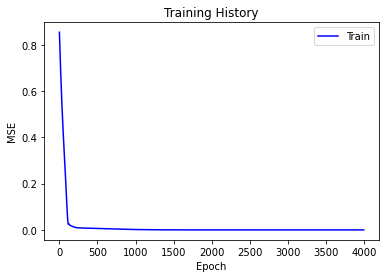

In [15]:
# 학습 history 출력. 
plt.plot(my_summary.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

#### 2.4. 예측:

In [16]:
n_ts_seed = 5                                 # Seed 길이.
n_predict_time_steps = 55                     # 예측할 길이.

In [17]:
# 예측 루프.
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model.predict(X)
    y_last= y_pred[0,-1,0]             # 마지막 출력이 바로 y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

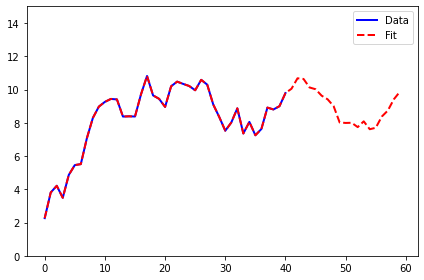

In [18]:
# 역변환을 하고 시계열을 출력한다.. 
ts = my_scaler.inverse_transform(ts_seed)
plt.plot(df.Value,c='b',linewidth=2, linestyle="-",label="Data")
plt.plot(ts,c='r',linewidth=2, linestyle="--",label="Fit")
plt.legend()
plt.ylim([0,15])
plt.tight_layout()
plt.savefig("out.png")
plt.show()